In [114]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d, langevin_dynamics_lsd
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [116]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
#     plt.scatter(x[:, 0], x[:, 1])
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [117]:
score_net = SmallMLP(n_dims=2, n_out=2)
critic_net = SmallMLP(n_dims=2, n_out=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 20000
itr = 0

losses = []

for epoch in range(epochs):
    tr_pts = sample_data('pinwheel', 4096).view(-1, 2)
    
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()

    tr_pts.requires_grad_()
    batch_size = tr_pts.size(0)

    perturbed_points = tr_pts

    score_pred = score_net(perturbed_points)

    critic_output = critic_net(perturbed_points)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)

    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()

    losses.append(loss)

    cycle_iter = itr % (k_iters + e_iters)

    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()

    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

#     if itr % cfg.log.save_freq == 0:
#         score_net.cpu()

#         torch.save({
#             'args': args,
#             'state_dict': score_net.state_dict(),
#         }, os.path.join(cfg.log.save_dir, 'checkpt.pth'))

#         score_net.to(device)

#     if itr % cfg.log.viz_freq == 0:
#         plt.clf()

#         #pt_cl, _ = langevin_dynamics(score_net, sigmas, dim=2, eps=1e-4, num_steps=cfg.inference.num_steps)
#         x_final = langevin_dynamics_lsd(score_net, l=1., e=.01, num_points=2048, n_steps=10)

#         visualize_2d(x_final)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'sample-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)


#         visualize_2d(perturbed_points)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'perturbed-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)

#     itr += 1

Epoch 0 (critic), Loss=0.03053 t1=0.01564 t2=0.01489
Epoch 1 (critic), Loss=0.35317 t1=-0.01376 t2=0.36693
Epoch 2 (critic), Loss=0.56838 t1=-0.03790 t2=0.60628
Epoch 3 (critic), Loss=0.63463 t1=-0.04130 t2=0.67593
Epoch 4 (critic), Loss=0.59487 t1=-0.04190 t2=0.63677
Epoch 5 (score), Loss=0.51808 t1=-0.03153 t2=0.54961
Epoch 6 (critic), Loss=0.28479 t1=-0.26555 t2=0.55034
Epoch 7 (critic), Loss=0.22390 t1=-0.18694 t2=0.41085
Epoch 8 (critic), Loss=0.16208 t1=-0.11009 t2=0.27218
Epoch 9 (critic), Loss=0.11338 t1=-0.04994 t2=0.16332
Epoch 10 (critic), Loss=0.08996 t1=-0.01051 t2=0.10047
Epoch 11 (score), Loss=0.08985 t1=0.00166 t2=0.08819
Epoch 12 (critic), Loss=0.06797 t1=-0.02120 t2=0.08917
Epoch 13 (critic), Loss=0.07131 t1=-0.00742 t2=0.07873
Epoch 14 (critic), Loss=0.07428 t1=0.00462 t2=0.06966
Epoch 15 (critic), Loss=0.07972 t1=0.01380 t2=0.06591
Epoch 16 (critic), Loss=0.09087 t1=0.01328 t2=0.07758
Epoch 17 (score), Loss=0.10242 t1=0.00017 t2=0.10225
Epoch 18 (critic), Loss=0.098

Epoch 170 (critic), Loss=5.35306 t1=-0.05091 t2=5.40396
Epoch 171 (critic), Loss=5.53509 t1=-0.09847 t2=5.63356
Epoch 172 (critic), Loss=5.45580 t1=-0.04104 t2=5.49684
Epoch 173 (score), Loss=5.65169 t1=0.00971 t2=5.64199
Epoch 174 (critic), Loss=5.57335 t1=-0.00217 t2=5.57552
Epoch 175 (critic), Loss=5.64500 t1=-0.06332 t2=5.70832
Epoch 176 (critic), Loss=5.88021 t1=-0.03674 t2=5.91695
Epoch 177 (critic), Loss=5.93866 t1=-0.05503 t2=5.99369
Epoch 178 (critic), Loss=5.94156 t1=-0.15559 t2=6.09716
Epoch 179 (score), Loss=5.97349 t1=-0.01598 t2=5.98947
Epoch 180 (critic), Loss=6.07790 t1=-0.04805 t2=6.12595
Epoch 181 (critic), Loss=6.18290 t1=0.12042 t2=6.06249
Epoch 182 (critic), Loss=6.22575 t1=0.00707 t2=6.21868
Epoch 183 (critic), Loss=6.31578 t1=-0.17731 t2=6.49308
Epoch 184 (critic), Loss=6.28776 t1=-0.04920 t2=6.33696
Epoch 185 (score), Loss=6.47462 t1=0.04669 t2=6.42793
Epoch 186 (critic), Loss=6.39309 t1=0.04217 t2=6.35092
Epoch 187 (critic), Loss=6.47409 t1=0.02424 t2=6.44985
E

Epoch 333 (critic), Loss=12.06586 t1=0.02596 t2=12.03990
Epoch 334 (critic), Loss=11.93982 t1=0.00436 t2=11.93546
Epoch 335 (score), Loss=12.15564 t1=0.14626 t2=12.00938
Epoch 336 (critic), Loss=12.15493 t1=0.06078 t2=12.09415
Epoch 337 (critic), Loss=12.23705 t1=0.23011 t2=12.00694
Epoch 338 (critic), Loss=12.01312 t1=0.05841 t2=11.95471
Epoch 339 (critic), Loss=12.02783 t1=-0.02494 t2=12.05277
Epoch 340 (critic), Loss=12.12925 t1=0.08783 t2=12.04142
Epoch 341 (score), Loss=12.14636 t1=0.12080 t2=12.02556
Epoch 342 (critic), Loss=12.12786 t1=0.02659 t2=12.10127
Epoch 343 (critic), Loss=12.33382 t1=0.08789 t2=12.24593
Epoch 344 (critic), Loss=12.15269 t1=-0.01256 t2=12.16524
Epoch 345 (critic), Loss=12.17842 t1=-0.19563 t2=12.37406
Epoch 346 (critic), Loss=12.36144 t1=0.09454 t2=12.26690
Epoch 347 (score), Loss=12.49824 t1=0.19916 t2=12.29908
Epoch 348 (critic), Loss=12.30726 t1=0.14606 t2=12.16120
Epoch 349 (critic), Loss=12.10663 t1=-0.19218 t2=12.29881
Epoch 350 (critic), Loss=12.21

Epoch 495 (critic), Loss=14.73483 t1=0.11458 t2=14.62025
Epoch 496 (critic), Loss=14.87485 t1=0.43620 t2=14.43865
Epoch 497 (score), Loss=14.96869 t1=0.65542 t2=14.31327
Epoch 498 (critic), Loss=14.80610 t1=0.58596 t2=14.22014
Epoch 499 (critic), Loss=14.93088 t1=0.46580 t2=14.46508
Epoch 500 (critic), Loss=14.75491 t1=0.09810 t2=14.65681
Epoch 501 (critic), Loss=14.62223 t1=0.08871 t2=14.53352
Epoch 502 (critic), Loss=14.87930 t1=0.30657 t2=14.57273
Epoch 503 (score), Loss=14.71869 t1=0.49965 t2=14.21904
Epoch 504 (critic), Loss=14.93229 t1=0.52508 t2=14.40720
Epoch 505 (critic), Loss=14.90609 t1=0.42502 t2=14.48107
Epoch 506 (critic), Loss=14.60181 t1=0.06049 t2=14.54132
Epoch 507 (critic), Loss=14.62828 t1=-0.05799 t2=14.68626
Epoch 508 (critic), Loss=14.80941 t1=0.06574 t2=14.74367
Epoch 509 (score), Loss=14.85213 t1=0.42220 t2=14.42993
Epoch 510 (critic), Loss=14.75956 t1=0.31288 t2=14.44669
Epoch 511 (critic), Loss=14.90501 t1=0.25050 t2=14.65451
Epoch 512 (critic), Loss=14.65104

Epoch 658 (critic), Loss=15.77070 t1=-0.08979 t2=15.86049
Epoch 659 (score), Loss=15.72039 t1=-0.10624 t2=15.82663
Epoch 660 (critic), Loss=15.88404 t1=-0.18732 t2=16.07135
Epoch 661 (critic), Loss=15.55316 t1=-0.32198 t2=15.87514
Epoch 662 (critic), Loss=15.45557 t1=-0.41720 t2=15.87277
Epoch 663 (critic), Loss=15.51122 t1=-0.20153 t2=15.71275
Epoch 664 (critic), Loss=15.71376 t1=-0.12842 t2=15.84218
Epoch 665 (score), Loss=15.85917 t1=-0.06701 t2=15.92618
Epoch 666 (critic), Loss=15.62621 t1=-0.14367 t2=15.76987
Epoch 667 (critic), Loss=15.61479 t1=-0.20778 t2=15.82257
Epoch 668 (critic), Loss=15.49066 t1=-0.34797 t2=15.83863
Epoch 669 (critic), Loss=15.74158 t1=-0.20614 t2=15.94772
Epoch 670 (critic), Loss=15.71081 t1=-0.13868 t2=15.84948
Epoch 671 (score), Loss=15.95226 t1=-0.00957 t2=15.96183
Epoch 672 (critic), Loss=15.78166 t1=0.00616 t2=15.77550
Epoch 673 (critic), Loss=15.92383 t1=-0.15887 t2=16.08270
Epoch 674 (critic), Loss=15.79407 t1=-0.33936 t2=16.13342
Epoch 675 (critic)

Epoch 820 (critic), Loss=16.50712 t1=0.13612 t2=16.37100
Epoch 821 (score), Loss=16.94468 t1=0.43773 t2=16.50695
Epoch 822 (critic), Loss=17.00125 t1=0.48527 t2=16.51597
Epoch 823 (critic), Loss=16.62246 t1=0.15189 t2=16.47057
Epoch 824 (critic), Loss=16.40573 t1=-0.12596 t2=16.53169
Epoch 825 (critic), Loss=16.09281 t1=-0.45908 t2=16.55189
Epoch 826 (critic), Loss=16.64569 t1=0.08736 t2=16.55833
Epoch 827 (score), Loss=16.92136 t1=0.25611 t2=16.66525
Epoch 828 (critic), Loss=16.82487 t1=0.16387 t2=16.66100
Epoch 829 (critic), Loss=16.68745 t1=0.20190 t2=16.48556
Epoch 830 (critic), Loss=16.37500 t1=-0.10002 t2=16.47502
Epoch 831 (critic), Loss=16.34674 t1=-0.30951 t2=16.65626
Epoch 832 (critic), Loss=16.43220 t1=-0.20651 t2=16.63870
Epoch 833 (score), Loss=16.88869 t1=0.28141 t2=16.60728
Epoch 834 (critic), Loss=16.61788 t1=0.14004 t2=16.47784
Epoch 835 (critic), Loss=17.03544 t1=0.20775 t2=16.82768
Epoch 836 (critic), Loss=16.51330 t1=-0.25030 t2=16.76361
Epoch 837 (critic), Loss=16.

Epoch 983 (score), Loss=17.13434 t1=-0.14864 t2=17.28298
Epoch 984 (critic), Loss=17.09559 t1=-0.21405 t2=17.30964
Epoch 985 (critic), Loss=17.22505 t1=-0.25883 t2=17.48387
Epoch 986 (critic), Loss=17.03032 t1=-0.20341 t2=17.23372
Epoch 987 (critic), Loss=17.14239 t1=-0.06289 t2=17.20528
Epoch 988 (critic), Loss=17.03261 t1=-0.10884 t2=17.14144
Epoch 989 (score), Loss=16.89800 t1=-0.36272 t2=17.26072
Epoch 990 (critic), Loss=17.02008 t1=-0.33136 t2=17.35144
Epoch 991 (critic), Loss=17.11568 t1=-0.40243 t2=17.51811
Epoch 992 (critic), Loss=17.06207 t1=-0.29785 t2=17.35992
Epoch 993 (critic), Loss=17.00538 t1=-0.13405 t2=17.13943
Epoch 994 (critic), Loss=16.98820 t1=-0.10616 t2=17.09436
Epoch 995 (score), Loss=16.96026 t1=-0.24146 t2=17.20172
Epoch 996 (critic), Loss=17.11476 t1=-0.09902 t2=17.21378
Epoch 997 (critic), Loss=17.21448 t1=-0.19808 t2=17.41257
Epoch 998 (critic), Loss=17.24596 t1=-0.31778 t2=17.56374
Epoch 999 (critic), Loss=17.06242 t1=-0.02660 t2=17.08902
Epoch 1000 (criti

Epoch 1145 (score), Loss=17.27055 t1=-0.30414 t2=17.57470
Epoch 1146 (critic), Loss=17.28747 t1=-0.39390 t2=17.68137
Epoch 1147 (critic), Loss=17.07113 t1=-0.31073 t2=17.38186
Epoch 1148 (critic), Loss=16.98900 t1=-0.27424 t2=17.26324
Epoch 1149 (critic), Loss=17.10690 t1=-0.40512 t2=17.51202
Epoch 1150 (critic), Loss=17.14265 t1=-0.35835 t2=17.50099
Epoch 1151 (score), Loss=17.33762 t1=-0.36107 t2=17.69868
Epoch 1152 (critic), Loss=17.14529 t1=-0.46429 t2=17.60959
Epoch 1153 (critic), Loss=17.19785 t1=-0.35815 t2=17.55600
Epoch 1154 (critic), Loss=17.25212 t1=-0.35193 t2=17.60405
Epoch 1155 (critic), Loss=17.26398 t1=-0.26230 t2=17.52627
Epoch 1156 (critic), Loss=17.04115 t1=-0.39335 t2=17.43450
Epoch 1157 (score), Loss=17.08006 t1=-0.55815 t2=17.63821
Epoch 1158 (critic), Loss=17.04559 t1=-0.59681 t2=17.64240
Epoch 1159 (critic), Loss=17.02025 t1=-0.42902 t2=17.44927
Epoch 1160 (critic), Loss=16.97109 t1=-0.38984 t2=17.36093
Epoch 1161 (critic), Loss=17.16347 t1=-0.32009 t2=17.48356


Epoch 1308 (critic), Loss=18.00131 t1=-0.23146 t2=18.23277
Epoch 1309 (critic), Loss=17.89222 t1=-0.06716 t2=17.95937
Epoch 1310 (critic), Loss=17.45114 t1=-0.37425 t2=17.82539
Epoch 1311 (critic), Loss=17.37815 t1=-0.46672 t2=17.84487
Epoch 1312 (critic), Loss=17.54738 t1=-0.50864 t2=18.05603
Epoch 1313 (score), Loss=17.85094 t1=-0.26328 t2=18.11423
Epoch 1314 (critic), Loss=17.48436 t1=-0.46204 t2=17.94640
Epoch 1315 (critic), Loss=17.67459 t1=-0.31740 t2=17.99200
Epoch 1316 (critic), Loss=17.63461 t1=-0.31284 t2=17.94745
Epoch 1317 (critic), Loss=17.46548 t1=-0.33937 t2=17.80485
Epoch 1318 (critic), Loss=17.21234 t1=-0.35281 t2=17.56515
Epoch 1319 (score), Loss=17.37540 t1=-0.29525 t2=17.67065
Epoch 1320 (critic), Loss=17.34272 t1=-0.40147 t2=17.74419
Epoch 1321 (critic), Loss=17.51438 t1=-0.32302 t2=17.83741
Epoch 1322 (critic), Loss=17.34990 t1=-0.29117 t2=17.64108
Epoch 1323 (critic), Loss=17.37757 t1=-0.11403 t2=17.49159
Epoch 1324 (critic), Loss=17.06281 t1=-0.29628 t2=17.35909

Epoch 1471 (critic), Loss=17.31479 t1=-0.52605 t2=17.84084
Epoch 1472 (critic), Loss=17.12861 t1=-0.69208 t2=17.82069
Epoch 1473 (critic), Loss=17.30835 t1=-0.50594 t2=17.81429
Epoch 1474 (critic), Loss=17.58156 t1=-0.43518 t2=18.01674
Epoch 1475 (score), Loss=17.42941 t1=-0.16478 t2=17.59419
Epoch 1476 (critic), Loss=16.97989 t1=-0.43104 t2=17.41093
Epoch 1477 (critic), Loss=17.25334 t1=-0.67743 t2=17.93078
Epoch 1478 (critic), Loss=17.25157 t1=-0.68089 t2=17.93245
Epoch 1479 (critic), Loss=17.40433 t1=-0.58932 t2=17.99366
Epoch 1480 (critic), Loss=17.33974 t1=-0.64521 t2=17.98495
Epoch 1481 (score), Loss=17.47731 t1=-0.30522 t2=17.78253
Epoch 1482 (critic), Loss=17.53396 t1=-0.58611 t2=18.12007
Epoch 1483 (critic), Loss=17.17494 t1=-0.40700 t2=17.58194
Epoch 1484 (critic), Loss=17.21601 t1=-0.68589 t2=17.90190
Epoch 1485 (critic), Loss=17.34158 t1=-0.67668 t2=18.01825
Epoch 1486 (critic), Loss=17.29135 t1=-0.69088 t2=17.98223
Epoch 1487 (score), Loss=17.28805 t1=-0.52887 t2=17.81692


Epoch 1633 (critic), Loss=18.10896 t1=0.08867 t2=18.02029
Epoch 1634 (critic), Loss=18.31395 t1=0.60856 t2=17.70539
Epoch 1635 (critic), Loss=18.02491 t1=0.03027 t2=17.99464
Epoch 1636 (critic), Loss=17.36411 t1=-0.52079 t2=17.88490
Epoch 1637 (score), Loss=17.29418 t1=-0.55477 t2=17.84894
Epoch 1638 (critic), Loss=17.26838 t1=-0.72846 t2=17.99683
Epoch 1639 (critic), Loss=17.92025 t1=0.16964 t2=17.75061
Epoch 1640 (critic), Loss=18.80062 t1=1.03781 t2=17.76280
Epoch 1641 (critic), Loss=18.32021 t1=0.46134 t2=17.85887
Epoch 1642 (critic), Loss=17.57969 t1=-0.37712 t2=17.95680
Epoch 1643 (score), Loss=17.39662 t1=-0.69375 t2=18.09037
Epoch 1644 (critic), Loss=17.35199 t1=-0.77234 t2=18.12433
Epoch 1645 (critic), Loss=17.88663 t1=0.10127 t2=17.78536
Epoch 1646 (critic), Loss=18.83061 t1=1.15105 t2=17.67956
Epoch 1647 (critic), Loss=18.47355 t1=0.86039 t2=17.61316
Epoch 1648 (critic), Loss=18.01418 t1=-0.02636 t2=18.04053
Epoch 1649 (score), Loss=17.41545 t1=-0.49587 t2=17.91133
Epoch 165

Epoch 1797 (critic), Loss=17.80709 t1=0.52290 t2=17.28419
Epoch 1798 (critic), Loss=18.17714 t1=1.22599 t2=16.95115
Epoch 1799 (score), Loss=18.20347 t1=1.12948 t2=17.07399
Epoch 1800 (critic), Loss=17.99576 t1=0.89272 t2=17.10304
Epoch 1801 (critic), Loss=17.36159 t1=0.28555 t2=17.07604
Epoch 1802 (critic), Loss=16.91168 t1=-0.10062 t2=17.01230
Epoch 1803 (critic), Loss=17.83022 t1=0.45361 t2=17.37660
Epoch 1804 (critic), Loss=17.87877 t1=0.53016 t2=17.34861
Epoch 1805 (score), Loss=17.94690 t1=0.72323 t2=17.22367
Epoch 1806 (critic), Loss=18.21830 t1=0.82185 t2=17.39645
Epoch 1807 (critic), Loss=18.01344 t1=0.38355 t2=17.62989
Epoch 1808 (critic), Loss=17.23008 t1=-0.43740 t2=17.66747
Epoch 1809 (critic), Loss=17.39224 t1=-0.26858 t2=17.66082
Epoch 1810 (critic), Loss=17.52017 t1=-0.00002 t2=17.52020
Epoch 1811 (score), Loss=17.73019 t1=0.37348 t2=17.35670
Epoch 1812 (critic), Loss=17.64284 t1=-0.01459 t2=17.65743
Epoch 1813 (critic), Loss=17.56931 t1=0.24060 t2=17.32871
Epoch 1814 (

Epoch 1959 (critic), Loss=16.51431 t1=-0.85280 t2=17.36712
Epoch 1960 (critic), Loss=16.70990 t1=-0.86359 t2=17.57349
Epoch 1961 (score), Loss=17.01007 t1=-0.64789 t2=17.65796
Epoch 1962 (critic), Loss=16.63831 t1=-0.79668 t2=17.43499
Epoch 1963 (critic), Loss=16.77391 t1=-0.76707 t2=17.54099
Epoch 1964 (critic), Loss=16.71614 t1=-0.85199 t2=17.56813
Epoch 1965 (critic), Loss=16.37455 t1=-0.91456 t2=17.28911
Epoch 1966 (critic), Loss=16.57646 t1=-0.99045 t2=17.56691
Epoch 1967 (score), Loss=16.67047 t1=-0.81116 t2=17.48162
Epoch 1968 (critic), Loss=16.73603 t1=-0.64681 t2=17.38284
Epoch 1969 (critic), Loss=16.90019 t1=-0.81035 t2=17.71053
Epoch 1970 (critic), Loss=16.47580 t1=-1.05596 t2=17.53177
Epoch 1971 (critic), Loss=16.45280 t1=-0.90369 t2=17.35649
Epoch 1972 (critic), Loss=16.71776 t1=-0.79730 t2=17.51505
Epoch 1973 (score), Loss=16.68311 t1=-0.84977 t2=17.53288
Epoch 1974 (critic), Loss=16.62533 t1=-0.97622 t2=17.60156
Epoch 1975 (critic), Loss=16.71197 t1=-0.94971 t2=17.66168


Epoch 2121 (critic), Loss=16.88555 t1=-0.72626 t2=17.61181
Epoch 2122 (critic), Loss=15.88809 t1=-1.36784 t2=17.25593
Epoch 2123 (score), Loss=16.09577 t1=-1.17335 t2=17.26913
Epoch 2124 (critic), Loss=15.96422 t1=-1.30528 t2=17.26950
Epoch 2125 (critic), Loss=16.65151 t1=-0.52513 t2=17.17665
Epoch 2126 (critic), Loss=16.99909 t1=-0.00606 t2=17.00516
Epoch 2127 (critic), Loss=16.93226 t1=-0.51221 t2=17.44447
Epoch 2128 (critic), Loss=16.26064 t1=-1.18387 t2=17.44450
Epoch 2129 (score), Loss=16.15505 t1=-1.19219 t2=17.34725
Epoch 2130 (critic), Loss=15.99679 t1=-1.31922 t2=17.31601
Epoch 2131 (critic), Loss=16.48532 t1=-0.60260 t2=17.08791
Epoch 2132 (critic), Loss=16.99916 t1=-0.01077 t2=17.00992
Epoch 2133 (critic), Loss=16.38417 t1=-0.44448 t2=16.82866
Epoch 2134 (critic), Loss=16.03740 t1=-1.18443 t2=17.22183
Epoch 2135 (score), Loss=15.95577 t1=-1.19861 t2=17.15438
Epoch 2136 (critic), Loss=15.66066 t1=-1.31545 t2=16.97611
Epoch 2137 (critic), Loss=16.68835 t1=-0.39768 t2=17.08603


Epoch 2280 (critic), Loss=17.01930 t1=0.30958 t2=16.70972
Epoch 2281 (critic), Loss=16.19964 t1=-0.59819 t2=16.79783
Epoch 2282 (critic), Loss=16.40054 t1=-0.50384 t2=16.90438
Epoch 2283 (critic), Loss=16.34111 t1=-0.22194 t2=16.56306
Epoch 2284 (critic), Loss=16.92439 t1=0.55178 t2=16.37260
Epoch 2285 (score), Loss=17.69304 t1=0.91990 t2=16.77314
Epoch 2286 (critic), Loss=16.86722 t1=0.09626 t2=16.77096
Epoch 2287 (critic), Loss=16.17734 t1=-0.44419 t2=16.62152
Epoch 2288 (critic), Loss=15.84885 t1=-0.86892 t2=16.71777
Epoch 2289 (critic), Loss=15.94816 t1=-0.75311 t2=16.70126
Epoch 2290 (critic), Loss=16.66831 t1=0.11460 t2=16.55371
Epoch 2291 (score), Loss=16.61084 t1=0.10796 t2=16.50288
Epoch 2292 (critic), Loss=16.12213 t1=-0.28438 t2=16.40650
Epoch 2293 (critic), Loss=15.59269 t1=-0.61259 t2=16.20528
Epoch 2294 (critic), Loss=16.11583 t1=-0.25220 t2=16.36803
Epoch 2295 (critic), Loss=16.44771 t1=-0.00238 t2=16.45009
Epoch 2296 (critic), Loss=16.26266 t1=0.03853 t2=16.22413
Epoch 

Epoch 2442 (critic), Loss=15.92729 t1=-0.69481 t2=16.62210
Epoch 2443 (critic), Loss=15.36897 t1=-0.94900 t2=16.31797
Epoch 2444 (critic), Loss=15.27735 t1=-1.14099 t2=16.41834
Epoch 2445 (critic), Loss=15.70782 t1=-0.68674 t2=16.39456
Epoch 2446 (critic), Loss=15.67214 t1=-0.51963 t2=16.19178
Epoch 2447 (score), Loss=15.83616 t1=-0.56709 t2=16.40325
Epoch 2448 (critic), Loss=15.78068 t1=-0.51793 t2=16.29862
Epoch 2449 (critic), Loss=15.76860 t1=-0.80402 t2=16.57263
Epoch 2450 (critic), Loss=15.39442 t1=-1.16879 t2=16.56321
Epoch 2451 (critic), Loss=15.05418 t1=-1.49035 t2=16.54453
Epoch 2452 (critic), Loss=15.76196 t1=-0.89809 t2=16.66005
Epoch 2453 (score), Loss=15.81491 t1=-0.33349 t2=16.14841
Epoch 2454 (critic), Loss=15.38544 t1=-0.86589 t2=16.25133
Epoch 2455 (critic), Loss=15.36109 t1=-0.77130 t2=16.13240
Epoch 2456 (critic), Loss=15.14712 t1=-1.18331 t2=16.33043
Epoch 2457 (critic), Loss=14.97582 t1=-1.54258 t2=16.51841
Epoch 2458 (critic), Loss=14.98117 t1=-1.50192 t2=16.48310

Epoch 2604 (critic), Loss=13.91372 t1=-2.21696 t2=16.13068
Epoch 2605 (critic), Loss=13.57297 t1=-2.34755 t2=15.92051
Epoch 2606 (critic), Loss=14.02315 t1=-2.04683 t2=16.06998
Epoch 2607 (critic), Loss=14.32236 t1=-1.61060 t2=15.93297
Epoch 2608 (critic), Loss=14.12014 t1=-1.68528 t2=15.80541
Epoch 2609 (score), Loss=14.06243 t1=-1.93841 t2=16.00085
Epoch 2610 (critic), Loss=13.85358 t1=-1.82981 t2=15.68339
Epoch 2611 (critic), Loss=13.89623 t1=-1.97751 t2=15.87374
Epoch 2612 (critic), Loss=14.02695 t1=-2.03186 t2=16.05881
Epoch 2613 (critic), Loss=13.67569 t1=-1.93657 t2=15.61226
Epoch 2614 (critic), Loss=14.38057 t1=-1.61786 t2=15.99843
Epoch 2615 (score), Loss=13.74520 t1=-1.83857 t2=15.58377
Epoch 2616 (critic), Loss=13.81113 t1=-1.73086 t2=15.54200
Epoch 2617 (critic), Loss=13.79101 t1=-2.00915 t2=15.80016
Epoch 2618 (critic), Loss=13.68677 t1=-2.27320 t2=15.95997
Epoch 2619 (critic), Loss=13.89446 t1=-2.18988 t2=16.08434
Epoch 2620 (critic), Loss=13.98370 t1=-2.00015 t2=15.98385

Epoch 2766 (critic), Loss=13.83631 t1=-1.64386 t2=15.48018
Epoch 2767 (critic), Loss=13.23565 t1=-2.22221 t2=15.45787
Epoch 2768 (critic), Loss=12.54390 t1=-2.44019 t2=14.98410
Epoch 2769 (critic), Loss=12.90314 t1=-2.27210 t2=15.17524
Epoch 2770 (critic), Loss=12.93779 t1=-1.86492 t2=14.80272
Epoch 2771 (score), Loss=13.81553 t1=-1.59116 t2=15.40669
Epoch 2772 (critic), Loss=13.07286 t1=-2.30587 t2=15.37873
Epoch 2773 (critic), Loss=12.91804 t1=-2.31861 t2=15.23666
Epoch 2774 (critic), Loss=12.58929 t1=-2.36927 t2=14.95855
Epoch 2775 (critic), Loss=12.71779 t1=-1.95071 t2=14.66850
Epoch 2776 (critic), Loss=13.20923 t1=-1.82426 t2=15.03349
Epoch 2777 (score), Loss=12.81474 t1=-2.19413 t2=15.00887
Epoch 2778 (critic), Loss=12.32617 t1=-2.49220 t2=14.81836
Epoch 2779 (critic), Loss=12.91517 t1=-2.26184 t2=15.17700
Epoch 2780 (critic), Loss=13.67878 t1=-1.38028 t2=15.05906
Epoch 2781 (critic), Loss=13.91694 t1=-1.00471 t2=14.92165
Epoch 2782 (critic), Loss=13.45349 t1=-1.53535 t2=14.98884

Epoch 2928 (critic), Loss=11.84451 t1=-2.69853 t2=14.54304
Epoch 2929 (critic), Loss=12.10481 t1=-2.56726 t2=14.67206
Epoch 2930 (critic), Loss=12.55994 t1=-2.01969 t2=14.57963
Epoch 2931 (critic), Loss=12.96064 t1=-1.45500 t2=14.41564
Epoch 2932 (critic), Loss=12.99206 t1=-1.65396 t2=14.64602
Epoch 2933 (score), Loss=12.20275 t1=-2.42071 t2=14.62346
Epoch 2934 (critic), Loss=12.45256 t1=-2.22912 t2=14.68168
Epoch 2935 (critic), Loss=11.75790 t1=-2.71989 t2=14.47779
Epoch 2936 (critic), Loss=12.28577 t1=-2.11295 t2=14.39872
Epoch 2937 (critic), Loss=12.84657 t1=-1.58416 t2=14.43073
Epoch 2938 (critic), Loss=14.02612 t1=-0.85277 t2=14.87889
Epoch 2939 (score), Loss=13.30347 t1=-1.17888 t2=14.48235
Epoch 2940 (critic), Loss=13.21427 t1=-1.46639 t2=14.68066
Epoch 2941 (critic), Loss=12.36576 t1=-1.91055 t2=14.27631
Epoch 2942 (critic), Loss=12.36005 t1=-2.12237 t2=14.48242
Epoch 2943 (critic), Loss=13.01365 t1=-1.94247 t2=14.95612
Epoch 2944 (critic), Loss=13.51978 t1=-1.19522 t2=14.71500

Epoch 3090 (critic), Loss=11.00391 t1=-2.80236 t2=13.80627
Epoch 3091 (critic), Loss=10.96506 t1=-2.84133 t2=13.80639
Epoch 3092 (critic), Loss=11.28678 t1=-2.35966 t2=13.64644
Epoch 3093 (critic), Loss=11.44610 t1=-2.18342 t2=13.62952
Epoch 3094 (critic), Loss=11.70385 t1=-1.99988 t2=13.70372
Epoch 3095 (score), Loss=11.33586 t1=-2.16887 t2=13.50473
Epoch 3096 (critic), Loss=11.38555 t1=-2.13416 t2=13.51970
Epoch 3097 (critic), Loss=10.86586 t1=-2.49440 t2=13.36026
Epoch 3098 (critic), Loss=11.53693 t1=-1.92321 t2=13.46014
Epoch 3099 (critic), Loss=12.36132 t1=-1.38994 t2=13.75127
Epoch 3100 (critic), Loss=11.97827 t1=-1.58749 t2=13.56576
Epoch 3101 (score), Loss=11.52447 t1=-2.12155 t2=13.64602
Epoch 3102 (critic), Loss=11.75125 t1=-2.02671 t2=13.77796
Epoch 3103 (critic), Loss=11.58274 t1=-2.40791 t2=13.99064
Epoch 3104 (critic), Loss=11.94896 t1=-1.88515 t2=13.83410
Epoch 3105 (critic), Loss=12.15285 t1=-1.47318 t2=13.62603
Epoch 3106 (critic), Loss=12.60861 t1=-1.28874 t2=13.89735

Epoch 3252 (critic), Loss=10.78196 t1=-2.85925 t2=13.64121
Epoch 3253 (critic), Loss=10.59984 t1=-2.80826 t2=13.40810
Epoch 3254 (critic), Loss=10.55613 t1=-2.76626 t2=13.32239
Epoch 3255 (critic), Loss=10.93930 t1=-2.39529 t2=13.33459
Epoch 3256 (critic), Loss=11.04497 t1=-2.37878 t2=13.42375
Epoch 3257 (score), Loss=10.60631 t1=-2.64518 t2=13.25149
Epoch 3258 (critic), Loss=10.46278 t1=-2.84898 t2=13.31175
Epoch 3259 (critic), Loss=10.67236 t1=-2.64770 t2=13.32006
Epoch 3260 (critic), Loss=10.49880 t1=-2.62316 t2=13.12196
Epoch 3261 (critic), Loss=11.27985 t1=-2.29124 t2=13.57108
Epoch 3262 (critic), Loss=10.63723 t1=-2.39109 t2=13.02832
Epoch 3263 (score), Loss=10.96999 t1=-2.23895 t2=13.20894
Epoch 3264 (critic), Loss=10.48116 t1=-2.62997 t2=13.11114
Epoch 3265 (critic), Loss=10.13027 t1=-2.93188 t2=13.06215
Epoch 3266 (critic), Loss=10.85626 t1=-2.58797 t2=13.44423
Epoch 3267 (critic), Loss=11.13283 t1=-2.13364 t2=13.26647
Epoch 3268 (critic), Loss=10.56588 t1=-2.56853 t2=13.13441

Epoch 3412 (critic), Loss=10.43752 t1=-1.96195 t2=12.39947
Epoch 3413 (score), Loss=10.10170 t1=-2.03644 t2=12.13814
Epoch 3414 (critic), Loss=10.21039 t1=-1.96932 t2=12.17971
Epoch 3415 (critic), Loss=9.60298 t1=-2.39099 t2=11.99397
Epoch 3416 (critic), Loss=9.24298 t1=-2.89534 t2=12.13831
Epoch 3417 (critic), Loss=9.73470 t1=-2.48699 t2=12.22170
Epoch 3418 (critic), Loss=9.88153 t1=-2.46207 t2=12.34360
Epoch 3419 (score), Loss=10.11399 t1=-2.32439 t2=12.43837
Epoch 3420 (critic), Loss=9.45210 t1=-2.58668 t2=12.03878
Epoch 3421 (critic), Loss=10.11534 t1=-2.28660 t2=12.40194
Epoch 3422 (critic), Loss=9.27133 t1=-2.98991 t2=12.26124
Epoch 3423 (critic), Loss=9.51951 t1=-2.58507 t2=12.10458
Epoch 3424 (critic), Loss=9.79494 t1=-2.26999 t2=12.06493
Epoch 3425 (score), Loss=9.61753 t1=-2.69503 t2=12.31256
Epoch 3426 (critic), Loss=9.65277 t1=-2.71944 t2=12.37221
Epoch 3427 (critic), Loss=9.37599 t1=-2.86793 t2=12.24392
Epoch 3428 (critic), Loss=9.33299 t1=-2.99729 t2=12.33028
Epoch 3429 (

Epoch 3574 (critic), Loss=9.03851 t1=-2.39570 t2=11.43422
Epoch 3575 (score), Loss=8.81908 t1=-2.32625 t2=11.14534
Epoch 3576 (critic), Loss=8.43991 t1=-2.67944 t2=11.11934
Epoch 3577 (critic), Loss=8.47882 t1=-2.65031 t2=11.12913
Epoch 3578 (critic), Loss=8.44278 t1=-2.79178 t2=11.23456
Epoch 3579 (critic), Loss=8.46675 t1=-2.94484 t2=11.41160
Epoch 3580 (critic), Loss=8.62242 t1=-3.12226 t2=11.74467
Epoch 3581 (score), Loss=8.80587 t1=-2.85561 t2=11.66148
Epoch 3582 (critic), Loss=8.73376 t1=-3.11266 t2=11.84642
Epoch 3583 (critic), Loss=8.38635 t1=-2.95656 t2=11.34291
Epoch 3584 (critic), Loss=8.54601 t1=-2.86472 t2=11.41073
Epoch 3585 (critic), Loss=8.92164 t1=-2.88108 t2=11.80272
Epoch 3586 (critic), Loss=8.54977 t1=-2.93256 t2=11.48233
Epoch 3587 (score), Loss=8.88988 t1=-2.68954 t2=11.57942
Epoch 3588 (critic), Loss=8.66765 t1=-3.01269 t2=11.68034
Epoch 3589 (critic), Loss=8.67707 t1=-2.81396 t2=11.49103
Epoch 3590 (critic), Loss=8.53998 t1=-3.11212 t2=11.65209
Epoch 3591 (criti

Epoch 3736 (critic), Loss=9.00475 t1=-1.72723 t2=10.73199
Epoch 3737 (score), Loss=9.78577 t1=-1.62965 t2=11.41542
Epoch 3738 (critic), Loss=8.90510 t1=-1.96320 t2=10.86830
Epoch 3739 (critic), Loss=8.29041 t1=-2.46230 t2=10.75271
Epoch 3740 (critic), Loss=8.46937 t1=-2.44896 t2=10.91832
Epoch 3741 (critic), Loss=8.38336 t1=-2.41786 t2=10.80122
Epoch 3742 (critic), Loss=8.97240 t1=-2.06173 t2=11.03413
Epoch 3743 (score), Loss=9.14746 t1=-1.75786 t2=10.90532
Epoch 3744 (critic), Loss=8.79122 t1=-2.33168 t2=11.12291
Epoch 3745 (critic), Loss=8.36352 t1=-2.53160 t2=10.89512
Epoch 3746 (critic), Loss=8.74205 t1=-2.26206 t2=11.00411
Epoch 3747 (critic), Loss=8.76605 t1=-2.20616 t2=10.97220
Epoch 3748 (critic), Loss=8.69570 t1=-2.00392 t2=10.69962
Epoch 3749 (score), Loss=8.63197 t1=-1.87935 t2=10.51132
Epoch 3750 (critic), Loss=8.28741 t1=-2.45025 t2=10.73766
Epoch 3751 (critic), Loss=8.11009 t1=-2.71297 t2=10.82306
Epoch 3752 (critic), Loss=8.45103 t1=-2.44250 t2=10.89353
Epoch 3753 (criti

Epoch 3900 (critic), Loss=7.42369 t1=-2.97939 t2=10.40308
Epoch 3901 (critic), Loss=7.11914 t1=-2.86611 t2=9.98525
Epoch 3902 (critic), Loss=7.09048 t1=-2.94489 t2=10.03536
Epoch 3903 (critic), Loss=7.45761 t1=-2.86161 t2=10.31921
Epoch 3904 (critic), Loss=7.25569 t1=-3.04865 t2=10.30434
Epoch 3905 (score), Loss=7.33615 t1=-2.96081 t2=10.29695
Epoch 3906 (critic), Loss=7.83058 t1=-2.83784 t2=10.66842
Epoch 3907 (critic), Loss=7.69133 t1=-2.71924 t2=10.41058
Epoch 3908 (critic), Loss=7.64665 t1=-2.66759 t2=10.31424
Epoch 3909 (critic), Loss=7.62560 t1=-2.73362 t2=10.35922
Epoch 3910 (critic), Loss=7.54966 t1=-2.63633 t2=10.18599
Epoch 3911 (score), Loss=7.55047 t1=-2.79974 t2=10.35021
Epoch 3912 (critic), Loss=8.02840 t1=-2.46235 t2=10.49074
Epoch 3913 (critic), Loss=7.58613 t1=-2.55366 t2=10.13979
Epoch 3914 (critic), Loss=7.89066 t1=-2.66680 t2=10.55746
Epoch 3915 (critic), Loss=7.31820 t1=-2.82264 t2=10.14084
Epoch 3916 (critic), Loss=7.55512 t1=-2.78616 t2=10.34129
Epoch 3917 (score

Epoch 4062 (critic), Loss=7.76550 t1=-1.51522 t2=9.28072
Epoch 4063 (critic), Loss=7.20979 t1=-2.28842 t2=9.49821
Epoch 4064 (critic), Loss=7.73387 t1=-1.96400 t2=9.69787
Epoch 4065 (critic), Loss=8.26177 t1=-1.15205 t2=9.41382
Epoch 4066 (critic), Loss=8.95269 t1=-0.50625 t2=9.45895
Epoch 4067 (score), Loss=8.12769 t1=-1.05912 t2=9.18681
Epoch 4068 (critic), Loss=7.93158 t1=-1.06787 t2=8.99945
Epoch 4069 (critic), Loss=7.67130 t1=-1.77340 t2=9.44469
Epoch 4070 (critic), Loss=7.62217 t1=-2.27515 t2=9.89732
Epoch 4071 (critic), Loss=7.88799 t1=-1.87557 t2=9.76356
Epoch 4072 (critic), Loss=8.69622 t1=-1.31464 t2=10.01087
Epoch 4073 (score), Loss=8.38348 t1=-1.12815 t2=9.51163
Epoch 4074 (critic), Loss=7.92000 t1=-1.60784 t2=9.52785
Epoch 4075 (critic), Loss=7.03282 t1=-2.40231 t2=9.43514
Epoch 4076 (critic), Loss=7.28801 t1=-2.73794 t2=10.02595
Epoch 4077 (critic), Loss=7.52266 t1=-2.76367 t2=10.28633
Epoch 4078 (critic), Loss=7.31865 t1=-2.32206 t2=9.64071
Epoch 4079 (score), Loss=7.371

Epoch 4224 (critic), Loss=6.43979 t1=-2.49860 t2=8.93839
Epoch 4225 (critic), Loss=6.13145 t1=-2.59510 t2=8.72655
Epoch 4226 (critic), Loss=6.47768 t1=-2.27870 t2=8.75638
Epoch 4227 (critic), Loss=6.07623 t1=-2.79127 t2=8.86750
Epoch 4228 (critic), Loss=6.40533 t1=-2.71257 t2=9.11790
Epoch 4229 (score), Loss=6.79404 t1=-2.30093 t2=9.09497
Epoch 4230 (critic), Loss=6.22880 t1=-2.48092 t2=8.70971
Epoch 4231 (critic), Loss=6.52868 t1=-2.38019 t2=8.90887
Epoch 4232 (critic), Loss=6.43626 t1=-2.26144 t2=8.69770
Epoch 4233 (critic), Loss=6.85775 t1=-2.15102 t2=9.00878
Epoch 4234 (critic), Loss=6.28916 t1=-2.74499 t2=9.03415
Epoch 4235 (score), Loss=6.41281 t1=-2.38315 t2=8.79597
Epoch 4236 (critic), Loss=6.20289 t1=-2.53552 t2=8.73841
Epoch 4237 (critic), Loss=6.32021 t1=-2.51202 t2=8.83223
Epoch 4238 (critic), Loss=6.64917 t1=-2.31309 t2=8.96226
Epoch 4239 (critic), Loss=6.34422 t1=-2.47342 t2=8.81764
Epoch 4240 (critic), Loss=6.84665 t1=-2.19021 t2=9.03686
Epoch 4241 (score), Loss=6.48922 

Epoch 4388 (critic), Loss=7.08517 t1=-1.71218 t2=8.79735
Epoch 4389 (critic), Loss=7.71200 t1=-1.07933 t2=8.79133
Epoch 4390 (critic), Loss=7.62878 t1=-0.81364 t2=8.44242
Epoch 4391 (score), Loss=7.52936 t1=-0.88378 t2=8.41314
Epoch 4392 (critic), Loss=7.82965 t1=-0.66698 t2=8.49663
Epoch 4393 (critic), Loss=7.39383 t1=-1.13678 t2=8.53061
Epoch 4394 (critic), Loss=7.19901 t1=-1.36191 t2=8.56092
Epoch 4395 (critic), Loss=7.28833 t1=-1.65234 t2=8.94067
Epoch 4396 (critic), Loss=7.47317 t1=-1.37731 t2=8.85049
Epoch 4397 (score), Loss=7.38211 t1=-1.45077 t2=8.83288
Epoch 4398 (critic), Loss=7.30902 t1=-1.74421 t2=9.05324
Epoch 4399 (critic), Loss=6.85987 t1=-1.92838 t2=8.78825
Epoch 4400 (critic), Loss=6.64151 t1=-2.36804 t2=9.00954
Epoch 4401 (critic), Loss=7.44968 t1=-1.59102 t2=9.04071
Epoch 4402 (critic), Loss=7.23738 t1=-1.76019 t2=8.99757
Epoch 4403 (score), Loss=7.10316 t1=-1.71045 t2=8.81361
Epoch 4404 (critic), Loss=6.43031 t1=-2.27450 t2=8.70481
Epoch 4405 (critic), Loss=6.84456 

Epoch 4550 (critic), Loss=6.00174 t1=-2.20983 t2=8.21157
Epoch 4551 (critic), Loss=5.71139 t1=-2.39636 t2=8.10774
Epoch 4552 (critic), Loss=5.57356 t1=-2.76059 t2=8.33415
Epoch 4553 (score), Loss=5.81045 t1=-2.58407 t2=8.39452
Epoch 4554 (critic), Loss=5.33165 t1=-2.77724 t2=8.10889
Epoch 4555 (critic), Loss=5.61644 t1=-2.70910 t2=8.32554
Epoch 4556 (critic), Loss=5.94663 t1=-2.43549 t2=8.38212
Epoch 4557 (critic), Loss=5.68398 t1=-2.76864 t2=8.45262
Epoch 4558 (critic), Loss=5.64194 t1=-2.50999 t2=8.15193
Epoch 4559 (score), Loss=5.55238 t1=-2.66048 t2=8.21286
Epoch 4560 (critic), Loss=5.23763 t1=-2.80258 t2=8.04021
Epoch 4561 (critic), Loss=5.47301 t1=-2.58343 t2=8.05643
Epoch 4562 (critic), Loss=5.58175 t1=-2.50419 t2=8.08594
Epoch 4563 (critic), Loss=6.08950 t1=-2.14358 t2=8.23309
Epoch 4564 (critic), Loss=5.77195 t1=-2.39736 t2=8.16932
Epoch 4565 (score), Loss=5.75515 t1=-2.67420 t2=8.42936
Epoch 4566 (critic), Loss=5.51316 t1=-2.67752 t2=8.19067
Epoch 4567 (critic), Loss=5.52177 

Epoch 4712 (critic), Loss=6.14946 t1=-1.52131 t2=7.67077
Epoch 4713 (critic), Loss=5.46319 t1=-2.02902 t2=7.49221
Epoch 4714 (critic), Loss=6.29483 t1=-1.62023 t2=7.91506
Epoch 4715 (score), Loss=6.19374 t1=-1.63584 t2=7.82957
Epoch 4716 (critic), Loss=6.24324 t1=-1.82396 t2=8.06719
Epoch 4717 (critic), Loss=6.25217 t1=-1.83490 t2=8.08707
Epoch 4718 (critic), Loss=5.87414 t1=-1.95923 t2=7.83337
Epoch 4719 (critic), Loss=5.85325 t1=-1.73857 t2=7.59182
Epoch 4720 (critic), Loss=5.98633 t1=-1.47149 t2=7.45782
Epoch 4721 (score), Loss=6.30223 t1=-1.77308 t2=8.07532
Epoch 4722 (critic), Loss=5.37173 t1=-2.43329 t2=7.80502
Epoch 4723 (critic), Loss=5.23136 t1=-2.54465 t2=7.77601
Epoch 4724 (critic), Loss=5.46153 t1=-2.46628 t2=7.92781
Epoch 4725 (critic), Loss=6.25546 t1=-1.51460 t2=7.77007
Epoch 4726 (critic), Loss=5.63404 t1=-1.59796 t2=7.23200
Epoch 4727 (score), Loss=5.47734 t1=-2.09893 t2=7.57627
Epoch 4728 (critic), Loss=5.24467 t1=-2.11554 t2=7.36021
Epoch 4729 (critic), Loss=5.74539 

Epoch 4875 (critic), Loss=5.89596 t1=-1.38463 t2=7.28059
Epoch 4876 (critic), Loss=5.94630 t1=-1.42147 t2=7.36777
Epoch 4877 (score), Loss=6.07282 t1=-1.02472 t2=7.09754
Epoch 4878 (critic), Loss=5.37034 t1=-1.35843 t2=6.72878
Epoch 4879 (critic), Loss=5.33154 t1=-1.41718 t2=6.74872
Epoch 4880 (critic), Loss=5.67964 t1=-1.24812 t2=6.92776
Epoch 4881 (critic), Loss=5.33001 t1=-1.51916 t2=6.84917
Epoch 4882 (critic), Loss=5.75325 t1=-1.74917 t2=7.50242
Epoch 4883 (score), Loss=5.61774 t1=-1.69678 t2=7.31452
Epoch 4884 (critic), Loss=5.61530 t1=-1.90830 t2=7.52360
Epoch 4885 (critic), Loss=5.80850 t1=-1.18984 t2=6.99834
Epoch 4886 (critic), Loss=5.39027 t1=-1.59996 t2=6.99023
Epoch 4887 (critic), Loss=5.23528 t1=-1.65104 t2=6.88633
Epoch 4888 (critic), Loss=5.44149 t1=-1.53199 t2=6.97348
Epoch 4889 (score), Loss=5.67552 t1=-1.77565 t2=7.45116
Epoch 4890 (critic), Loss=5.37730 t1=-1.95576 t2=7.33306
Epoch 4891 (critic), Loss=5.54426 t1=-2.00294 t2=7.54719
Epoch 4892 (critic), Loss=5.23081 

Epoch 5038 (critic), Loss=6.40558 t1=-0.75242 t2=7.15800
Epoch 5039 (score), Loss=5.98577 t1=-1.48795 t2=7.47372
Epoch 5040 (critic), Loss=5.35097 t1=-1.65072 t2=7.00169
Epoch 5041 (critic), Loss=5.02730 t1=-2.01303 t2=7.04032
Epoch 5042 (critic), Loss=5.25812 t1=-1.51708 t2=6.77519
Epoch 5043 (critic), Loss=5.78105 t1=-1.41589 t2=7.19694
Epoch 5044 (critic), Loss=6.03717 t1=-1.05406 t2=7.09123
Epoch 5045 (score), Loss=5.60166 t1=-1.64162 t2=7.24328
Epoch 5046 (critic), Loss=5.82978 t1=-1.77991 t2=7.60970
Epoch 5047 (critic), Loss=5.63699 t1=-1.79723 t2=7.43422
Epoch 5048 (critic), Loss=4.83983 t1=-2.32869 t2=7.16852
Epoch 5049 (critic), Loss=5.21495 t1=-1.86344 t2=7.07840
Epoch 5050 (critic), Loss=5.50248 t1=-1.55975 t2=7.06223
Epoch 5051 (score), Loss=5.66729 t1=-1.25491 t2=6.92220
Epoch 5052 (critic), Loss=5.00447 t1=-1.94153 t2=6.94600
Epoch 5053 (critic), Loss=4.84194 t1=-2.14288 t2=6.98482
Epoch 5054 (critic), Loss=4.86056 t1=-1.97069 t2=6.83125
Epoch 5055 (critic), Loss=5.13851 

Epoch 5199 (critic), Loss=5.73553 t1=-1.13948 t2=6.87501
Epoch 5200 (critic), Loss=5.98989 t1=-0.59427 t2=6.58417
Epoch 5201 (score), Loss=6.01107 t1=-0.67322 t2=6.68428
Epoch 5202 (critic), Loss=5.61910 t1=-1.22814 t2=6.84725
Epoch 5203 (critic), Loss=5.09792 t1=-1.43313 t2=6.53104
Epoch 5204 (critic), Loss=5.13770 t1=-1.68491 t2=6.82262
Epoch 5205 (critic), Loss=5.25951 t1=-1.64815 t2=6.90766
Epoch 5206 (critic), Loss=5.02812 t1=-1.69516 t2=6.72328
Epoch 5207 (score), Loss=5.99527 t1=-1.12611 t2=7.12138
Epoch 5208 (critic), Loss=5.86957 t1=-1.30294 t2=7.17251
Epoch 5209 (critic), Loss=5.07788 t1=-1.89556 t2=6.97344
Epoch 5210 (critic), Loss=4.92834 t1=-2.00593 t2=6.93427
Epoch 5211 (critic), Loss=4.76952 t1=-2.20650 t2=6.97602
Epoch 5212 (critic), Loss=4.96252 t1=-2.08527 t2=7.04779
Epoch 5213 (score), Loss=5.29277 t1=-1.91971 t2=7.21247
Epoch 5214 (critic), Loss=5.18488 t1=-2.01408 t2=7.19896
Epoch 5215 (critic), Loss=5.00748 t1=-2.15331 t2=7.16079
Epoch 5216 (critic), Loss=4.72487 

Epoch 5361 (critic), Loss=4.97946 t1=-1.60216 t2=6.58162
Epoch 5362 (critic), Loss=5.01344 t1=-1.60017 t2=6.61361
Epoch 5363 (score), Loss=5.01505 t1=-1.85305 t2=6.86810
Epoch 5364 (critic), Loss=5.10279 t1=-1.66851 t2=6.77131
Epoch 5365 (critic), Loss=5.38160 t1=-1.32643 t2=6.70802
Epoch 5366 (critic), Loss=4.55375 t1=-1.50131 t2=6.05505
Epoch 5367 (critic), Loss=5.22590 t1=-1.40833 t2=6.63423
Epoch 5368 (critic), Loss=5.23769 t1=-1.25743 t2=6.49513
Epoch 5369 (score), Loss=5.12693 t1=-1.22875 t2=6.35568
Epoch 5370 (critic), Loss=4.81066 t1=-1.65110 t2=6.46176
Epoch 5371 (critic), Loss=4.89102 t1=-1.77014 t2=6.66116
Epoch 5372 (critic), Loss=4.71646 t1=-1.75504 t2=6.47150
Epoch 5373 (critic), Loss=4.92584 t1=-1.59314 t2=6.51898
Epoch 5374 (critic), Loss=5.46128 t1=-1.14135 t2=6.60263
Epoch 5375 (score), Loss=5.40990 t1=-1.28666 t2=6.69656
Epoch 5376 (critic), Loss=5.11740 t1=-1.52466 t2=6.64206
Epoch 5377 (critic), Loss=5.21782 t1=-1.74126 t2=6.95908
Epoch 5378 (critic), Loss=4.68008 

Epoch 5522 (critic), Loss=4.47362 t1=-1.66754 t2=6.14117
Epoch 5523 (critic), Loss=4.53125 t1=-1.54856 t2=6.07981
Epoch 5524 (critic), Loss=4.63841 t1=-1.34375 t2=5.98216
Epoch 5525 (score), Loss=5.11992 t1=-1.12382 t2=6.24375
Epoch 5526 (critic), Loss=4.97215 t1=-1.25072 t2=6.22287
Epoch 5527 (critic), Loss=4.43836 t1=-1.92159 t2=6.35995
Epoch 5528 (critic), Loss=5.30830 t1=-1.07791 t2=6.38622
Epoch 5529 (critic), Loss=5.06727 t1=-1.29092 t2=6.35819
Epoch 5530 (critic), Loss=4.93420 t1=-1.15510 t2=6.08930
Epoch 5531 (score), Loss=4.70588 t1=-1.60636 t2=6.31225
Epoch 5532 (critic), Loss=4.51115 t1=-1.73159 t2=6.24274
Epoch 5533 (critic), Loss=4.68633 t1=-2.00194 t2=6.68827
Epoch 5534 (critic), Loss=5.38403 t1=-1.39809 t2=6.78212
Epoch 5535 (critic), Loss=5.13004 t1=-1.49837 t2=6.62842
Epoch 5536 (critic), Loss=5.73244 t1=-0.98566 t2=6.71810
Epoch 5537 (score), Loss=5.10682 t1=-1.33659 t2=6.44341
Epoch 5538 (critic), Loss=5.17658 t1=-1.44005 t2=6.61663
Epoch 5539 (critic), Loss=4.52602 

Epoch 5684 (critic), Loss=4.35074 t1=-2.08620 t2=6.43693
Epoch 5685 (critic), Loss=4.62959 t1=-1.80191 t2=6.43150
Epoch 5686 (critic), Loss=4.97468 t1=-1.83243 t2=6.80712
Epoch 5687 (score), Loss=5.18931 t1=-1.64290 t2=6.83220
Epoch 5688 (critic), Loss=5.11913 t1=-1.90109 t2=7.02021
Epoch 5689 (critic), Loss=5.16690 t1=-1.84196 t2=7.00886
Epoch 5690 (critic), Loss=4.67679 t1=-2.04159 t2=6.71838
Epoch 5691 (critic), Loss=4.49155 t1=-1.85523 t2=6.34678
Epoch 5692 (critic), Loss=5.06559 t1=-1.86286 t2=6.92844
Epoch 5693 (score), Loss=4.67877 t1=-1.95958 t2=6.63835
Epoch 5694 (critic), Loss=4.69752 t1=-1.93262 t2=6.63014
Epoch 5695 (critic), Loss=4.87376 t1=-2.19086 t2=7.06463
Epoch 5696 (critic), Loss=4.57684 t1=-2.23773 t2=6.81457
Epoch 5697 (critic), Loss=4.67821 t1=-1.91899 t2=6.59720
Epoch 5698 (critic), Loss=4.71747 t1=-1.73965 t2=6.45711
Epoch 5699 (score), Loss=4.47130 t1=-2.02016 t2=6.49146
Epoch 5700 (critic), Loss=4.62863 t1=-1.98509 t2=6.61373
Epoch 5701 (critic), Loss=4.30036 

Epoch 5846 (critic), Loss=3.90462 t1=-1.87243 t2=5.77705
Epoch 5847 (critic), Loss=4.99515 t1=-1.12082 t2=6.11597
Epoch 5848 (critic), Loss=5.52055 t1=-0.29378 t2=5.81434
Epoch 5849 (score), Loss=5.34730 t1=-0.50380 t2=5.85111
Epoch 5850 (critic), Loss=4.94545 t1=-0.94468 t2=5.89012
Epoch 5851 (critic), Loss=4.70985 t1=-1.31403 t2=6.02389
Epoch 5852 (critic), Loss=4.61694 t1=-1.51187 t2=6.12881
Epoch 5853 (critic), Loss=4.50502 t1=-1.55676 t2=6.06178
Epoch 5854 (critic), Loss=4.39932 t1=-1.21917 t2=5.61849
Epoch 5855 (score), Loss=5.05139 t1=-0.76226 t2=5.81365
Epoch 5856 (critic), Loss=4.26522 t1=-1.45101 t2=5.71623
Epoch 5857 (critic), Loss=4.13344 t1=-1.63582 t2=5.76926
Epoch 5858 (critic), Loss=4.26178 t1=-1.72245 t2=5.98424
Epoch 5859 (critic), Loss=4.70950 t1=-1.45902 t2=6.16852
Epoch 5860 (critic), Loss=4.35932 t1=-1.48427 t2=5.84359
Epoch 5861 (score), Loss=4.18347 t1=-1.57477 t2=5.75825
Epoch 5862 (critic), Loss=4.37783 t1=-1.47452 t2=5.85235
Epoch 5863 (critic), Loss=4.05770 

Epoch 6008 (critic), Loss=4.37996 t1=-1.49836 t2=5.87832
Epoch 6009 (critic), Loss=4.99118 t1=-0.81864 t2=5.80982
Epoch 6010 (critic), Loss=4.52166 t1=-1.11637 t2=5.63803
Epoch 6011 (score), Loss=4.54186 t1=-1.56172 t2=6.10358
Epoch 6012 (critic), Loss=4.20588 t1=-1.93515 t2=6.14104
Epoch 6013 (critic), Loss=4.66759 t1=-1.54985 t2=6.21744
Epoch 6014 (critic), Loss=4.17677 t1=-1.67793 t2=5.85470
Epoch 6015 (critic), Loss=4.70593 t1=-1.39306 t2=6.09900
Epoch 6016 (critic), Loss=4.21052 t1=-1.64375 t2=5.85428
Epoch 6017 (score), Loss=4.22656 t1=-1.65518 t2=5.88175
Epoch 6018 (critic), Loss=4.14964 t1=-1.60081 t2=5.75045
Epoch 6019 (critic), Loss=3.92271 t1=-1.77129 t2=5.69401
Epoch 6020 (critic), Loss=4.64405 t1=-1.47831 t2=6.12236
Epoch 6021 (critic), Loss=4.06992 t1=-1.98088 t2=6.05080
Epoch 6022 (critic), Loss=3.96262 t1=-1.73606 t2=5.69867
Epoch 6023 (score), Loss=3.95470 t1=-1.89574 t2=5.85045
Epoch 6024 (critic), Loss=4.23882 t1=-1.72533 t2=5.96414
Epoch 6025 (critic), Loss=3.98982 

Epoch 6170 (critic), Loss=4.51011 t1=-0.71275 t2=5.22286
Epoch 6171 (critic), Loss=4.53112 t1=-1.03566 t2=5.56678
Epoch 6172 (critic), Loss=4.47689 t1=-0.83672 t2=5.31361
Epoch 6173 (score), Loss=5.23966 t1=-0.13219 t2=5.37185
Epoch 6174 (critic), Loss=3.99287 t1=-1.30940 t2=5.30228
Epoch 6175 (critic), Loss=3.99037 t1=-1.58647 t2=5.57685
Epoch 6176 (critic), Loss=4.16721 t1=-1.16987 t2=5.33708
Epoch 6177 (critic), Loss=4.32386 t1=-1.18100 t2=5.50486
Epoch 6178 (critic), Loss=4.56694 t1=-1.20675 t2=5.77369
Epoch 6179 (score), Loss=4.54625 t1=-1.08395 t2=5.63020
Epoch 6180 (critic), Loss=3.67237 t1=-1.59663 t2=5.26900
Epoch 6181 (critic), Loss=3.81407 t1=-1.75527 t2=5.56934
Epoch 6182 (critic), Loss=4.32170 t1=-1.23842 t2=5.56012
Epoch 6183 (critic), Loss=5.14551 t1=-0.38809 t2=5.53360
Epoch 6184 (critic), Loss=5.38580 t1=-0.18803 t2=5.57383
Epoch 6185 (score), Loss=4.95097 t1=-0.37815 t2=5.32912
Epoch 6186 (critic), Loss=5.20620 t1=-0.33663 t2=5.54283
Epoch 6187 (critic), Loss=4.34113 

Epoch 6332 (critic), Loss=3.79079 t1=-1.92609 t2=5.71688
Epoch 6333 (critic), Loss=3.73309 t1=-2.23170 t2=5.96479
Epoch 6334 (critic), Loss=3.80688 t1=-2.05411 t2=5.86098
Epoch 6335 (score), Loss=3.91094 t1=-1.73557 t2=5.64651
Epoch 6336 (critic), Loss=3.66513 t1=-2.01312 t2=5.67826
Epoch 6337 (critic), Loss=3.58243 t1=-2.25555 t2=5.83798
Epoch 6338 (critic), Loss=3.89600 t1=-1.86594 t2=5.76194
Epoch 6339 (critic), Loss=3.85295 t1=-1.92285 t2=5.77580
Epoch 6340 (critic), Loss=4.20494 t1=-1.76714 t2=5.97208
Epoch 6341 (score), Loss=3.87202 t1=-2.01863 t2=5.89065
Epoch 6342 (critic), Loss=3.71393 t1=-1.98696 t2=5.70090
Epoch 6343 (critic), Loss=3.90614 t1=-1.84366 t2=5.74980
Epoch 6344 (critic), Loss=3.83619 t1=-1.81982 t2=5.65601
Epoch 6345 (critic), Loss=3.84701 t1=-1.91004 t2=5.75705
Epoch 6346 (critic), Loss=3.75124 t1=-1.91575 t2=5.66699
Epoch 6347 (score), Loss=3.90819 t1=-1.92084 t2=5.82902
Epoch 6348 (critic), Loss=4.01828 t1=-1.96056 t2=5.97884
Epoch 6349 (critic), Loss=4.18657 

Epoch 6495 (critic), Loss=4.10337 t1=-1.28687 t2=5.39024
Epoch 6496 (critic), Loss=4.31369 t1=-1.32655 t2=5.64024
Epoch 6497 (score), Loss=3.78758 t1=-1.51261 t2=5.30020
Epoch 6498 (critic), Loss=3.91929 t1=-1.56195 t2=5.48124
Epoch 6499 (critic), Loss=3.80955 t1=-1.68080 t2=5.49035
Epoch 6500 (critic), Loss=4.46874 t1=-1.17917 t2=5.64791
Epoch 6501 (critic), Loss=4.58576 t1=-0.73530 t2=5.32105
Epoch 6502 (critic), Loss=4.24660 t1=-0.99131 t2=5.23791
Epoch 6503 (score), Loss=4.10286 t1=-1.54063 t2=5.64350
Epoch 6504 (critic), Loss=3.98591 t1=-1.34874 t2=5.33466
Epoch 6505 (critic), Loss=3.91844 t1=-1.40725 t2=5.32569
Epoch 6506 (critic), Loss=4.34938 t1=-1.04139 t2=5.39077
Epoch 6507 (critic), Loss=5.16267 t1=-0.61493 t2=5.77761
Epoch 6508 (critic), Loss=4.65978 t1=-1.02769 t2=5.68747
Epoch 6509 (score), Loss=4.39761 t1=-1.23024 t2=5.62785
Epoch 6510 (critic), Loss=3.99595 t1=-1.41307 t2=5.40902
Epoch 6511 (critic), Loss=4.02071 t1=-1.26069 t2=5.28140
Epoch 6512 (critic), Loss=4.36335 

Epoch 6655 (critic), Loss=4.26208 t1=-1.05787 t2=5.31994
Epoch 6656 (critic), Loss=4.52997 t1=-0.62365 t2=5.15362
Epoch 6657 (critic), Loss=5.47274 t1=0.53258 t2=4.94016
Epoch 6658 (critic), Loss=5.42633 t1=0.23524 t2=5.19110
Epoch 6659 (score), Loss=4.58715 t1=-0.41630 t2=5.00345
Epoch 6660 (critic), Loss=4.62098 t1=-0.43107 t2=5.05205
Epoch 6661 (critic), Loss=4.33940 t1=-0.90650 t2=5.24590
Epoch 6662 (critic), Loss=4.58530 t1=-0.42938 t2=5.01468
Epoch 6663 (critic), Loss=5.20690 t1=0.05172 t2=5.15517
Epoch 6664 (critic), Loss=5.35299 t1=0.42755 t2=4.92544
Epoch 6665 (score), Loss=5.59087 t1=0.58491 t2=5.00596
Epoch 6666 (critic), Loss=4.70314 t1=-0.30162 t2=5.00476
Epoch 6667 (critic), Loss=4.32315 t1=-0.58816 t2=4.91131
Epoch 6668 (critic), Loss=4.52226 t1=-0.74144 t2=5.26369
Epoch 6669 (critic), Loss=3.92662 t1=-0.97712 t2=4.90374
Epoch 6670 (critic), Loss=4.28338 t1=-1.05098 t2=5.33435
Epoch 6671 (score), Loss=4.76464 t1=-0.62858 t2=5.39321
Epoch 6672 (critic), Loss=3.98525 t1=-1

Epoch 6817 (critic), Loss=3.91386 t1=-1.26949 t2=5.18335
Epoch 6818 (critic), Loss=3.89732 t1=-1.49845 t2=5.39578
Epoch 6819 (critic), Loss=3.66646 t1=-1.80715 t2=5.47361
Epoch 6820 (critic), Loss=3.59221 t1=-1.72767 t2=5.31988
Epoch 6821 (score), Loss=3.37655 t1=-1.88127 t2=5.25782
Epoch 6822 (critic), Loss=3.75327 t1=-1.67531 t2=5.42858
Epoch 6823 (critic), Loss=3.40410 t1=-1.82556 t2=5.22966
Epoch 6824 (critic), Loss=3.44689 t1=-1.70079 t2=5.14768
Epoch 6825 (critic), Loss=3.54638 t1=-1.48434 t2=5.03072
Epoch 6826 (critic), Loss=3.77590 t1=-1.20273 t2=4.97863
Epoch 6827 (score), Loss=3.51207 t1=-1.57300 t2=5.08507
Epoch 6828 (critic), Loss=3.74745 t1=-1.35047 t2=5.09792
Epoch 6829 (critic), Loss=3.82421 t1=-1.74494 t2=5.56915
Epoch 6830 (critic), Loss=4.09419 t1=-1.53106 t2=5.62526
Epoch 6831 (critic), Loss=3.04893 t1=-1.86105 t2=4.90997
Epoch 6832 (critic), Loss=3.61044 t1=-1.70735 t2=5.31779
Epoch 6833 (score), Loss=3.58147 t1=-1.36942 t2=4.95090
Epoch 6834 (critic), Loss=3.17646 

Epoch 6979 (critic), Loss=3.49497 t1=-1.42523 t2=4.92020
Epoch 6980 (critic), Loss=3.53481 t1=-1.39201 t2=4.92682
Epoch 6981 (critic), Loss=3.55857 t1=-1.16452 t2=4.72309
Epoch 6982 (critic), Loss=3.91260 t1=-0.88932 t2=4.80192
Epoch 6983 (score), Loss=4.49342 t1=-0.55240 t2=5.04581
Epoch 6984 (critic), Loss=3.90839 t1=-1.25733 t2=5.16572
Epoch 6985 (critic), Loss=3.92208 t1=-1.14537 t2=5.06744
Epoch 6986 (critic), Loss=3.81898 t1=-1.14606 t2=4.96504
Epoch 6987 (critic), Loss=3.47609 t1=-1.41108 t2=4.88717
Epoch 6988 (critic), Loss=3.61065 t1=-0.94557 t2=4.55621
Epoch 6989 (score), Loss=3.65463 t1=-0.95607 t2=4.61070
Epoch 6990 (critic), Loss=3.71063 t1=-1.15818 t2=4.86881
Epoch 6991 (critic), Loss=3.71282 t1=-1.47613 t2=5.18894
Epoch 6992 (critic), Loss=3.76311 t1=-1.48223 t2=5.24534
Epoch 6993 (critic), Loss=3.12247 t1=-1.76876 t2=4.89123
Epoch 6994 (critic), Loss=3.63650 t1=-1.72777 t2=5.36427
Epoch 6995 (score), Loss=3.79473 t1=-1.47083 t2=5.26556
Epoch 6996 (critic), Loss=4.07613 

Epoch 7141 (critic), Loss=3.46710 t1=-1.26173 t2=4.72883
Epoch 7142 (critic), Loss=3.94557 t1=-1.32713 t2=5.27270
Epoch 7143 (critic), Loss=3.47986 t1=-1.47444 t2=4.95431
Epoch 7144 (critic), Loss=4.03685 t1=-1.22489 t2=5.26174
Epoch 7145 (score), Loss=3.81064 t1=-1.45945 t2=5.27009
Epoch 7146 (critic), Loss=3.63278 t1=-1.47535 t2=5.10813
Epoch 7147 (critic), Loss=3.82061 t1=-1.37695 t2=5.19756
Epoch 7148 (critic), Loss=3.25424 t1=-1.90949 t2=5.16372
Epoch 7149 (critic), Loss=3.39913 t1=-1.36448 t2=4.76361
Epoch 7150 (critic), Loss=3.24152 t1=-1.75202 t2=4.99355
Epoch 7151 (score), Loss=3.65723 t1=-1.37118 t2=5.02841
Epoch 7152 (critic), Loss=3.04881 t1=-2.19748 t2=5.24628
Epoch 7153 (critic), Loss=3.19270 t1=-2.10540 t2=5.29810
Epoch 7154 (critic), Loss=3.75474 t1=-1.40113 t2=5.15587
Epoch 7155 (critic), Loss=3.67293 t1=-1.36182 t2=5.03475
Epoch 7156 (critic), Loss=3.55863 t1=-1.36413 t2=4.92277
Epoch 7157 (score), Loss=3.85878 t1=-1.29594 t2=5.15472
Epoch 7158 (critic), Loss=3.62231 

Epoch 7302 (critic), Loss=3.04190 t1=-1.52517 t2=4.56707
Epoch 7303 (critic), Loss=2.85001 t1=-1.64286 t2=4.49287
Epoch 7304 (critic), Loss=2.99487 t1=-1.80651 t2=4.80138
Epoch 7305 (critic), Loss=3.37967 t1=-1.45511 t2=4.83478
Epoch 7306 (critic), Loss=3.37427 t1=-1.36278 t2=4.73705
Epoch 7307 (score), Loss=3.39787 t1=-1.59545 t2=4.99332
Epoch 7308 (critic), Loss=3.34736 t1=-1.67595 t2=5.02331
Epoch 7309 (critic), Loss=3.15019 t1=-1.31202 t2=4.46221
Epoch 7310 (critic), Loss=3.10808 t1=-1.61413 t2=4.72221
Epoch 7311 (critic), Loss=3.46652 t1=-1.56702 t2=5.03354
Epoch 7312 (critic), Loss=3.03538 t1=-1.80731 t2=4.84270
Epoch 7313 (score), Loss=3.15088 t1=-1.76755 t2=4.91843
Epoch 7314 (critic), Loss=3.48773 t1=-1.54485 t2=5.03258
Epoch 7315 (critic), Loss=3.56942 t1=-1.51728 t2=5.08670
Epoch 7316 (critic), Loss=3.50107 t1=-1.33923 t2=4.84030
Epoch 7317 (critic), Loss=3.35714 t1=-1.55559 t2=4.91273
Epoch 7318 (critic), Loss=3.40435 t1=-1.29652 t2=4.70087
Epoch 7319 (score), Loss=4.23569 

Epoch 7464 (critic), Loss=3.39045 t1=-1.33488 t2=4.72534
Epoch 7465 (critic), Loss=3.57110 t1=-1.28552 t2=4.85663
Epoch 7466 (critic), Loss=3.89609 t1=-1.00172 t2=4.89781
Epoch 7467 (critic), Loss=3.93709 t1=-0.73377 t2=4.67085
Epoch 7468 (critic), Loss=4.14140 t1=-0.61564 t2=4.75704
Epoch 7469 (score), Loss=3.77072 t1=-1.06459 t2=4.83531
Epoch 7470 (critic), Loss=4.07244 t1=-0.58814 t2=4.66058
Epoch 7471 (critic), Loss=3.47658 t1=-1.48982 t2=4.96640
Epoch 7472 (critic), Loss=4.07363 t1=-0.84564 t2=4.91928
Epoch 7473 (critic), Loss=3.93482 t1=-0.91040 t2=4.84522
Epoch 7474 (critic), Loss=3.95866 t1=-0.90542 t2=4.86408
Epoch 7475 (score), Loss=3.90143 t1=-0.85524 t2=4.75667
Epoch 7476 (critic), Loss=4.05419 t1=-0.82679 t2=4.88098
Epoch 7477 (critic), Loss=3.37193 t1=-1.49788 t2=4.86981
Epoch 7478 (critic), Loss=3.13876 t1=-1.68678 t2=4.82555
Epoch 7479 (critic), Loss=3.49498 t1=-1.30660 t2=4.80158
Epoch 7480 (critic), Loss=3.43823 t1=-0.97370 t2=4.41193
Epoch 7481 (score), Loss=3.74825 

Epoch 7626 (critic), Loss=3.25387 t1=-1.51000 t2=4.76388
Epoch 7627 (critic), Loss=3.31816 t1=-1.76234 t2=5.08050
Epoch 7628 (critic), Loss=3.38147 t1=-1.54266 t2=4.92412
Epoch 7629 (critic), Loss=3.36469 t1=-1.37758 t2=4.74227
Epoch 7630 (critic), Loss=3.26026 t1=-1.47194 t2=4.73219
Epoch 7631 (score), Loss=2.94283 t1=-1.59239 t2=4.53523
Epoch 7632 (critic), Loss=2.73438 t1=-1.59098 t2=4.32536
Epoch 7633 (critic), Loss=3.42858 t1=-1.39984 t2=4.82842
Epoch 7634 (critic), Loss=3.63820 t1=-1.11151 t2=4.74971
Epoch 7635 (critic), Loss=3.50286 t1=-1.44541 t2=4.94828
Epoch 7636 (critic), Loss=3.09858 t1=-1.45372 t2=4.55230
Epoch 7637 (score), Loss=3.04010 t1=-1.53682 t2=4.57693
Epoch 7638 (critic), Loss=3.72878 t1=-0.90145 t2=4.63023
Epoch 7639 (critic), Loss=3.11204 t1=-1.32719 t2=4.43923
Epoch 7640 (critic), Loss=3.69564 t1=-1.07748 t2=4.77312
Epoch 7641 (critic), Loss=3.34485 t1=-1.61264 t2=4.95749
Epoch 7642 (critic), Loss=3.32943 t1=-1.50966 t2=4.83909
Epoch 7643 (score), Loss=3.30367 

Epoch 7783 (critic), Loss=3.62406 t1=-1.05491 t2=4.67897
Epoch 7784 (critic), Loss=3.47770 t1=-0.86703 t2=4.34473
Epoch 7785 (critic), Loss=4.01461 t1=-0.19287 t2=4.20747
Epoch 7786 (critic), Loss=4.00483 t1=-0.22119 t2=4.22602
Epoch 7787 (score), Loss=3.96512 t1=-0.31638 t2=4.28150
Epoch 7788 (critic), Loss=3.69235 t1=-0.70264 t2=4.39499
Epoch 7789 (critic), Loss=3.29264 t1=-1.04226 t2=4.33490
Epoch 7790 (critic), Loss=3.90848 t1=-0.43642 t2=4.34489
Epoch 7791 (critic), Loss=3.87881 t1=-0.17539 t2=4.05420
Epoch 7792 (critic), Loss=4.54285 t1=0.28159 t2=4.26125
Epoch 7793 (score), Loss=3.98346 t1=-0.12098 t2=4.10444
Epoch 7794 (critic), Loss=3.71823 t1=-0.52446 t2=4.24268
Epoch 7795 (critic), Loss=3.33255 t1=-0.90569 t2=4.23824
Epoch 7796 (critic), Loss=3.59478 t1=-0.89488 t2=4.48965
Epoch 7797 (critic), Loss=3.06166 t1=-1.01444 t2=4.07610
Epoch 7798 (critic), Loss=3.39785 t1=-1.03601 t2=4.43386
Epoch 7799 (score), Loss=3.95410 t1=-0.33556 t2=4.28967
Epoch 7800 (critic), Loss=3.49466 t

Epoch 7944 (critic), Loss=2.99269 t1=-1.23528 t2=4.22796
Epoch 7945 (critic), Loss=3.25446 t1=-0.66668 t2=3.92113
Epoch 7946 (critic), Loss=2.96308 t1=-1.05282 t2=4.01590
Epoch 7947 (critic), Loss=2.87752 t1=-1.35395 t2=4.23148
Epoch 7948 (critic), Loss=2.94018 t1=-1.28313 t2=4.22331
Epoch 7949 (score), Loss=2.90327 t1=-1.15977 t2=4.06304
Epoch 7950 (critic), Loss=2.55556 t1=-1.48968 t2=4.04524
Epoch 7951 (critic), Loss=2.50464 t1=-1.57384 t2=4.07848
Epoch 7952 (critic), Loss=2.83952 t1=-1.32551 t2=4.16503
Epoch 7953 (critic), Loss=2.94647 t1=-1.10596 t2=4.05243
Epoch 7954 (critic), Loss=2.97345 t1=-0.98798 t2=3.96143
Epoch 7955 (score), Loss=3.02116 t1=-1.27887 t2=4.30003
Epoch 7956 (critic), Loss=2.98261 t1=-1.19254 t2=4.17515
Epoch 7957 (critic), Loss=3.28336 t1=-1.29021 t2=4.57357
Epoch 7958 (critic), Loss=3.31248 t1=-1.15981 t2=4.47229
Epoch 7959 (critic), Loss=3.88720 t1=-0.52298 t2=4.41018
Epoch 7960 (critic), Loss=3.30608 t1=-1.04681 t2=4.35289
Epoch 7961 (score), Loss=3.18752 

Epoch 8106 (critic), Loss=2.89178 t1=-1.64051 t2=4.53229
Epoch 8107 (critic), Loss=2.99077 t1=-1.66264 t2=4.65342
Epoch 8108 (critic), Loss=3.10952 t1=-1.55732 t2=4.66684
Epoch 8109 (critic), Loss=2.90846 t1=-2.05898 t2=4.96744
Epoch 8110 (critic), Loss=2.87551 t1=-1.75249 t2=4.62800
Epoch 8111 (score), Loss=3.55967 t1=-1.38008 t2=4.93975
Epoch 8112 (critic), Loss=3.47515 t1=-1.30043 t2=4.77558
Epoch 8113 (critic), Loss=2.92588 t1=-1.55910 t2=4.48498
Epoch 8114 (critic), Loss=2.87278 t1=-1.69895 t2=4.57173
Epoch 8115 (critic), Loss=2.81302 t1=-1.46709 t2=4.28011
Epoch 8116 (critic), Loss=2.95011 t1=-1.77313 t2=4.72325
Epoch 8117 (score), Loss=3.33516 t1=-1.46943 t2=4.80459
Epoch 8118 (critic), Loss=2.84886 t1=-1.94714 t2=4.79600
Epoch 8119 (critic), Loss=2.70040 t1=-1.91861 t2=4.61901
Epoch 8120 (critic), Loss=2.31299 t1=-1.87879 t2=4.19178
Epoch 8121 (critic), Loss=3.20695 t1=-1.39562 t2=4.60257
Epoch 8122 (critic), Loss=2.69121 t1=-1.74532 t2=4.43653
Epoch 8123 (score), Loss=2.72113 

Epoch 8268 (critic), Loss=4.70401 t1=0.30755 t2=4.39645
Epoch 8269 (critic), Loss=3.25739 t1=-0.77119 t2=4.02858
Epoch 8270 (critic), Loss=3.18984 t1=-0.65832 t2=3.84816
Epoch 8271 (critic), Loss=4.77392 t1=0.60582 t2=4.16810
Epoch 8272 (critic), Loss=5.68386 t1=1.19309 t2=4.49077
Epoch 8273 (score), Loss=4.99973 t1=0.80909 t2=4.19064
Epoch 8274 (critic), Loss=4.98487 t1=0.63965 t2=4.34522
Epoch 8275 (critic), Loss=3.79057 t1=-0.48546 t2=4.27603
Epoch 8276 (critic), Loss=3.59987 t1=-0.84391 t2=4.44378
Epoch 8277 (critic), Loss=3.58713 t1=-1.12672 t2=4.71384
Epoch 8278 (critic), Loss=4.41007 t1=0.05235 t2=4.35772
Epoch 8279 (score), Loss=5.13486 t1=0.62875 t2=4.50611
Epoch 8280 (critic), Loss=3.83862 t1=-0.74203 t2=4.58065
Epoch 8281 (critic), Loss=3.38699 t1=-1.25049 t2=4.63748
Epoch 8282 (critic), Loss=2.82451 t1=-1.38923 t2=4.21374
Epoch 8283 (critic), Loss=3.28454 t1=-1.24923 t2=4.53377
Epoch 8284 (critic), Loss=3.02049 t1=-1.26105 t2=4.28154
Epoch 8285 (score), Loss=3.45524 t1=-0.8

Epoch 8434 (critic), Loss=2.73278 t1=-1.66839 t2=4.40117
Epoch 8435 (score), Loss=2.88303 t1=-1.38312 t2=4.26615
Epoch 8436 (critic), Loss=3.04535 t1=-1.32832 t2=4.37367
Epoch 8437 (critic), Loss=2.78656 t1=-1.55247 t2=4.33903
Epoch 8438 (critic), Loss=3.21008 t1=-1.22181 t2=4.43189
Epoch 8439 (critic), Loss=3.22070 t1=-1.07566 t2=4.29636
Epoch 8440 (critic), Loss=3.07369 t1=-1.35484 t2=4.42853
Epoch 8441 (score), Loss=2.96219 t1=-1.41542 t2=4.37761
Epoch 8442 (critic), Loss=2.62072 t1=-1.89262 t2=4.51334
Epoch 8443 (critic), Loss=2.75872 t1=-1.72927 t2=4.48799
Epoch 8444 (critic), Loss=2.80954 t1=-1.65819 t2=4.46772
Epoch 8445 (critic), Loss=3.11666 t1=-1.33482 t2=4.45148
Epoch 8446 (critic), Loss=2.48537 t1=-1.71924 t2=4.20461
Epoch 8447 (score), Loss=2.74396 t1=-1.36069 t2=4.10465
Epoch 8448 (critic), Loss=3.15868 t1=-1.18762 t2=4.34630
Epoch 8449 (critic), Loss=2.87474 t1=-1.23275 t2=4.10749
Epoch 8450 (critic), Loss=2.43829 t1=-1.63389 t2=4.07218
Epoch 8451 (critic), Loss=2.60687 

Epoch 8600 (critic), Loss=3.38028 t1=-0.86454 t2=4.24482
Epoch 8601 (critic), Loss=3.29170 t1=-1.17738 t2=4.46908
Epoch 8602 (critic), Loss=3.60767 t1=-0.91571 t2=4.52338
Epoch 8603 (score), Loss=3.37884 t1=-1.35317 t2=4.73201
Epoch 8604 (critic), Loss=3.24345 t1=-1.33512 t2=4.57857
Epoch 8605 (critic), Loss=3.37320 t1=-1.29115 t2=4.66435
Epoch 8606 (critic), Loss=3.84294 t1=-0.36047 t2=4.20341
Epoch 8607 (critic), Loss=4.41661 t1=-0.19835 t2=4.61496
Epoch 8608 (critic), Loss=4.10609 t1=0.07552 t2=4.03056
Epoch 8609 (score), Loss=3.25178 t1=-0.94547 t2=4.19725
Epoch 8610 (critic), Loss=3.31444 t1=-0.66682 t2=3.98126
Epoch 8611 (critic), Loss=3.62134 t1=-0.82914 t2=4.45048
Epoch 8612 (critic), Loss=4.28101 t1=-0.30526 t2=4.58627
Epoch 8613 (critic), Loss=4.87321 t1=0.42498 t2=4.44823
Epoch 8614 (critic), Loss=4.62445 t1=0.22209 t2=4.40236
Epoch 8615 (score), Loss=3.99421 t1=-0.42534 t2=4.41956
Epoch 8616 (critic), Loss=3.68864 t1=-0.88466 t2=4.57329
Epoch 8617 (critic), Loss=2.99073 t1=

Epoch 8755 (critic), Loss=3.24167 t1=-1.09961 t2=4.34127
Epoch 8756 (critic), Loss=3.67240 t1=-0.77805 t2=4.45045
Epoch 8757 (critic), Loss=3.38544 t1=-0.76391 t2=4.14935
Epoch 8758 (critic), Loss=3.26590 t1=-0.75054 t2=4.01644
Epoch 8759 (score), Loss=3.41638 t1=-0.67679 t2=4.09317
Epoch 8760 (critic), Loss=3.37350 t1=-1.14540 t2=4.51890
Epoch 8761 (critic), Loss=3.01831 t1=-1.18001 t2=4.19832
Epoch 8762 (critic), Loss=3.08326 t1=-1.03207 t2=4.11533
Epoch 8763 (critic), Loss=2.88722 t1=-1.12945 t2=4.01667
Epoch 8764 (critic), Loss=3.01908 t1=-0.92765 t2=3.94673
Epoch 8765 (score), Loss=3.22599 t1=-1.07945 t2=4.30544
Epoch 8766 (critic), Loss=3.18253 t1=-0.89117 t2=4.07370
Epoch 8767 (critic), Loss=3.01284 t1=-1.06374 t2=4.07658
Epoch 8768 (critic), Loss=2.82652 t1=-1.11646 t2=3.94297
Epoch 8769 (critic), Loss=2.65859 t1=-1.04797 t2=3.70657
Epoch 8770 (critic), Loss=2.99680 t1=-0.91385 t2=3.91065
Epoch 8771 (score), Loss=3.09444 t1=-0.95432 t2=4.04875
Epoch 8772 (critic), Loss=2.75012 

Epoch 8917 (critic), Loss=2.24720 t1=-1.69011 t2=3.93731
Epoch 8918 (critic), Loss=2.99823 t1=-1.31461 t2=4.31285
Epoch 8919 (critic), Loss=2.60195 t1=-1.69089 t2=4.29284
Epoch 8920 (critic), Loss=2.75846 t1=-1.44936 t2=4.20783
Epoch 8921 (score), Loss=2.13923 t1=-1.85857 t2=3.99779
Epoch 8922 (critic), Loss=2.93705 t1=-1.12507 t2=4.06212
Epoch 8923 (critic), Loss=2.37015 t1=-1.67661 t2=4.04677
Epoch 8924 (critic), Loss=2.74760 t1=-1.41309 t2=4.16070
Epoch 8925 (critic), Loss=2.96435 t1=-1.10448 t2=4.06883
Epoch 8926 (critic), Loss=2.71322 t1=-1.24006 t2=3.95328
Epoch 8927 (score), Loss=2.96145 t1=-1.10184 t2=4.06329
Epoch 8928 (critic), Loss=2.43986 t1=-1.47191 t2=3.91176
Epoch 8929 (critic), Loss=2.58834 t1=-1.54154 t2=4.12988
Epoch 8930 (critic), Loss=2.58921 t1=-1.51589 t2=4.10509
Epoch 8931 (critic), Loss=2.72306 t1=-1.21000 t2=3.93306
Epoch 8932 (critic), Loss=2.83509 t1=-1.28854 t2=4.12363
Epoch 8933 (score), Loss=2.59834 t1=-1.37510 t2=3.97344
Epoch 8934 (critic), Loss=2.65178 

Epoch 9079 (critic), Loss=2.46258 t1=-1.53981 t2=4.00239
Epoch 9080 (critic), Loss=2.73524 t1=-1.38455 t2=4.11979
Epoch 9081 (critic), Loss=2.70916 t1=-1.03989 t2=3.74905
Epoch 9082 (critic), Loss=3.20724 t1=-0.70006 t2=3.90730
Epoch 9083 (score), Loss=2.82973 t1=-1.16510 t2=3.99483
Epoch 9084 (critic), Loss=2.52433 t1=-1.23072 t2=3.75505
Epoch 9085 (critic), Loss=2.64459 t1=-1.30671 t2=3.95130
Epoch 9086 (critic), Loss=3.09760 t1=-0.99169 t2=4.08928
Epoch 9087 (critic), Loss=2.80091 t1=-1.00141 t2=3.80232
Epoch 9088 (critic), Loss=3.03717 t1=-0.75202 t2=3.78919
Epoch 9089 (score), Loss=2.87240 t1=-0.96534 t2=3.83774
Epoch 9090 (critic), Loss=2.55990 t1=-1.15434 t2=3.71424
Epoch 9091 (critic), Loss=2.90745 t1=-0.95513 t2=3.86259
Epoch 9092 (critic), Loss=2.88330 t1=-0.93370 t2=3.81699
Epoch 9093 (critic), Loss=3.54800 t1=-0.41728 t2=3.96528
Epoch 9094 (critic), Loss=3.34202 t1=-0.53376 t2=3.87577
Epoch 9095 (score), Loss=3.14822 t1=-0.65899 t2=3.80721
Epoch 9096 (critic), Loss=3.46272 

Epoch 9241 (critic), Loss=2.71129 t1=-0.97337 t2=3.68466
Epoch 9242 (critic), Loss=2.60049 t1=-1.13158 t2=3.73207
Epoch 9243 (critic), Loss=3.11853 t1=-0.89883 t2=4.01735
Epoch 9244 (critic), Loss=2.88415 t1=-1.18019 t2=4.06434
Epoch 9245 (score), Loss=2.59254 t1=-1.52854 t2=4.12107
Epoch 9246 (critic), Loss=2.59664 t1=-1.48968 t2=4.08632
Epoch 9247 (critic), Loss=2.62783 t1=-1.36806 t2=3.99590
Epoch 9248 (critic), Loss=2.35388 t1=-1.36878 t2=3.72266
Epoch 9249 (critic), Loss=2.75247 t1=-1.23091 t2=3.98338
Epoch 9250 (critic), Loss=3.30403 t1=-0.62327 t2=3.92730
Epoch 9251 (score), Loss=3.18866 t1=-0.74958 t2=3.93824
Epoch 9252 (critic), Loss=2.38345 t1=-1.30412 t2=3.68758
Epoch 9253 (critic), Loss=2.46100 t1=-1.24067 t2=3.70167
Epoch 9254 (critic), Loss=2.32586 t1=-1.12699 t2=3.45285
Epoch 9255 (critic), Loss=2.62085 t1=-1.39609 t2=4.01694
Epoch 9256 (critic), Loss=3.02088 t1=-1.13627 t2=4.15715
Epoch 9257 (score), Loss=2.87839 t1=-0.65449 t2=3.53288
Epoch 9258 (critic), Loss=2.21564 

Epoch 9403 (critic), Loss=2.57549 t1=-1.45558 t2=4.03108
Epoch 9404 (critic), Loss=2.58112 t1=-1.25384 t2=3.83496
Epoch 9405 (critic), Loss=2.80342 t1=-1.30832 t2=4.11174
Epoch 9406 (critic), Loss=2.60306 t1=-1.15097 t2=3.75403
Epoch 9407 (score), Loss=2.60289 t1=-1.31032 t2=3.91321
Epoch 9408 (critic), Loss=2.13304 t1=-1.53549 t2=3.66852
Epoch 9409 (critic), Loss=2.57272 t1=-1.15562 t2=3.72834
Epoch 9410 (critic), Loss=3.10829 t1=-0.65079 t2=3.75908
Epoch 9411 (critic), Loss=3.35763 t1=-0.34963 t2=3.70726
Epoch 9412 (critic), Loss=3.01537 t1=-0.73901 t2=3.75438
Epoch 9413 (score), Loss=2.99747 t1=-0.82434 t2=3.82181
Epoch 9414 (critic), Loss=2.68460 t1=-1.10290 t2=3.78750
Epoch 9415 (critic), Loss=2.61579 t1=-0.96634 t2=3.58213
Epoch 9416 (critic), Loss=3.16005 t1=-0.59516 t2=3.75521
Epoch 9417 (critic), Loss=3.27394 t1=-0.40423 t2=3.67818
Epoch 9418 (critic), Loss=3.22320 t1=-0.32982 t2=3.55302
Epoch 9419 (score), Loss=3.47016 t1=-0.09292 t2=3.56309
Epoch 9420 (critic), Loss=3.12784 

Epoch 9565 (critic), Loss=3.18424 t1=-0.52719 t2=3.71143
Epoch 9566 (critic), Loss=2.52833 t1=-1.24955 t2=3.77787
Epoch 9567 (critic), Loss=2.76638 t1=-1.30627 t2=4.07265
Epoch 9568 (critic), Loss=2.99117 t1=-1.28729 t2=4.27846
Epoch 9569 (score), Loss=2.58883 t1=-1.50050 t2=4.08933
Epoch 9570 (critic), Loss=2.44879 t1=-1.44522 t2=3.89401
Epoch 9571 (critic), Loss=2.72408 t1=-1.40097 t2=4.12506
Epoch 9572 (critic), Loss=2.59507 t1=-1.22413 t2=3.81920
Epoch 9573 (critic), Loss=2.73509 t1=-0.97462 t2=3.70970
Epoch 9574 (critic), Loss=2.66520 t1=-1.12943 t2=3.79462
Epoch 9575 (score), Loss=2.47767 t1=-1.34445 t2=3.82212
Epoch 9576 (critic), Loss=2.61001 t1=-1.57236 t2=4.18236
Epoch 9577 (critic), Loss=2.40122 t1=-1.55615 t2=3.95737
Epoch 9578 (critic), Loss=2.31688 t1=-1.38194 t2=3.69883
Epoch 9579 (critic), Loss=3.07966 t1=-0.62683 t2=3.70649
Epoch 9580 (critic), Loss=2.98369 t1=-0.98486 t2=3.96856
Epoch 9581 (score), Loss=2.65211 t1=-1.20317 t2=3.85528
Epoch 9582 (critic), Loss=2.58618 

Epoch 9725 (score), Loss=3.09080 t1=-0.81640 t2=3.90720
Epoch 9726 (critic), Loss=3.17860 t1=-0.63951 t2=3.81811
Epoch 9727 (critic), Loss=2.69719 t1=-0.84489 t2=3.54208
Epoch 9728 (critic), Loss=2.50291 t1=-1.18824 t2=3.69115
Epoch 9729 (critic), Loss=3.10643 t1=-0.79910 t2=3.90553
Epoch 9730 (critic), Loss=2.97656 t1=-0.97048 t2=3.94703
Epoch 9731 (score), Loss=2.98736 t1=-0.59984 t2=3.58720
Epoch 9732 (critic), Loss=3.17685 t1=-0.42684 t2=3.60368
Epoch 9733 (critic), Loss=2.32929 t1=-1.32606 t2=3.65535
Epoch 9734 (critic), Loss=2.58092 t1=-1.43492 t2=4.01584
Epoch 9735 (critic), Loss=2.49746 t1=-0.95158 t2=3.44905
Epoch 9736 (critic), Loss=2.46534 t1=-1.19505 t2=3.66040
Epoch 9737 (score), Loss=2.52319 t1=-1.17741 t2=3.70059
Epoch 9738 (critic), Loss=2.12392 t1=-1.67518 t2=3.79910
Epoch 9739 (critic), Loss=2.26258 t1=-1.52876 t2=3.79134
Epoch 9740 (critic), Loss=2.50400 t1=-1.45478 t2=3.95878
Epoch 9741 (critic), Loss=2.61432 t1=-1.27786 t2=3.89218
Epoch 9742 (critic), Loss=2.67402 

Epoch 9887 (score), Loss=3.63365 t1=-0.06223 t2=3.69588
Epoch 9888 (critic), Loss=2.48838 t1=-1.26639 t2=3.75478
Epoch 9889 (critic), Loss=2.48230 t1=-1.19533 t2=3.67763
Epoch 9890 (critic), Loss=2.38934 t1=-1.20841 t2=3.59775
Epoch 9891 (critic), Loss=2.08623 t1=-1.55059 t2=3.63682
Epoch 9892 (critic), Loss=2.15307 t1=-1.38590 t2=3.53897
Epoch 9893 (score), Loss=3.17506 t1=-0.68656 t2=3.86161
Epoch 9894 (critic), Loss=2.39743 t1=-1.17911 t2=3.57654
Epoch 9895 (critic), Loss=2.40663 t1=-1.35026 t2=3.75688
Epoch 9896 (critic), Loss=2.37184 t1=-1.16095 t2=3.53279
Epoch 9897 (critic), Loss=2.67600 t1=-1.27167 t2=3.94767
Epoch 9898 (critic), Loss=2.85861 t1=-1.00778 t2=3.86639
Epoch 9899 (score), Loss=2.60062 t1=-1.35609 t2=3.95671
Epoch 9900 (critic), Loss=2.63709 t1=-1.15944 t2=3.79653
Epoch 9901 (critic), Loss=2.25243 t1=-1.29168 t2=3.54411
Epoch 9902 (critic), Loss=2.74896 t1=-1.09699 t2=3.84595
Epoch 9903 (critic), Loss=2.88038 t1=-0.93676 t2=3.81714
Epoch 9904 (critic), Loss=3.19490 

Epoch 10049 (score), Loss=3.04412 t1=-0.74728 t2=3.79140
Epoch 10050 (critic), Loss=3.13550 t1=-1.00666 t2=4.14215
Epoch 10051 (critic), Loss=3.30696 t1=-1.03299 t2=4.33995
Epoch 10052 (critic), Loss=3.09906 t1=-0.96166 t2=4.06072
Epoch 10053 (critic), Loss=2.82220 t1=-1.33669 t2=4.15889
Epoch 10054 (critic), Loss=3.14830 t1=-0.88385 t2=4.03215
Epoch 10055 (score), Loss=2.92049 t1=-0.99882 t2=3.91931
Epoch 10056 (critic), Loss=2.79967 t1=-1.11342 t2=3.91308
Epoch 10057 (critic), Loss=2.65364 t1=-1.29357 t2=3.94720
Epoch 10058 (critic), Loss=2.74305 t1=-1.05049 t2=3.79355
Epoch 10059 (critic), Loss=2.57679 t1=-1.39478 t2=3.97157
Epoch 10060 (critic), Loss=2.84719 t1=-1.03391 t2=3.88110
Epoch 10061 (score), Loss=2.44406 t1=-1.25843 t2=3.70249
Epoch 10062 (critic), Loss=1.93974 t1=-1.65979 t2=3.59954
Epoch 10063 (critic), Loss=2.23622 t1=-1.43900 t2=3.67523
Epoch 10064 (critic), Loss=2.57587 t1=-1.14750 t2=3.72337
Epoch 10065 (critic), Loss=2.98958 t1=-0.86464 t2=3.85422
Epoch 10066 (crit

Epoch 10212 (critic), Loss=2.30199 t1=-1.47371 t2=3.77571
Epoch 10213 (critic), Loss=2.42815 t1=-1.24262 t2=3.67077
Epoch 10214 (critic), Loss=2.13911 t1=-1.49335 t2=3.63246
Epoch 10215 (critic), Loss=2.54789 t1=-1.32220 t2=3.87009
Epoch 10216 (critic), Loss=2.31344 t1=-1.25142 t2=3.56486
Epoch 10217 (score), Loss=2.22999 t1=-1.15029 t2=3.38028
Epoch 10218 (critic), Loss=2.12991 t1=-1.06152 t2=3.19144
Epoch 10219 (critic), Loss=2.17979 t1=-1.32014 t2=3.49993
Epoch 10220 (critic), Loss=2.81683 t1=-0.78490 t2=3.60172
Epoch 10221 (critic), Loss=2.10290 t1=-1.22684 t2=3.32974
Epoch 10222 (critic), Loss=2.96175 t1=-0.58999 t2=3.55174
Epoch 10223 (score), Loss=2.46454 t1=-1.09923 t2=3.56376
Epoch 10224 (critic), Loss=2.64809 t1=-1.06318 t2=3.71127
Epoch 10225 (critic), Loss=2.34343 t1=-1.18897 t2=3.53241
Epoch 10226 (critic), Loss=2.33711 t1=-1.15852 t2=3.49564
Epoch 10227 (critic), Loss=2.56031 t1=-0.82959 t2=3.38991
Epoch 10228 (critic), Loss=3.09191 t1=-0.41561 t2=3.50752
Epoch 10229 (sco

Epoch 10375 (critic), Loss=2.49687 t1=-1.10340 t2=3.60027
Epoch 10376 (critic), Loss=2.09062 t1=-1.41466 t2=3.50528
Epoch 10377 (critic), Loss=2.39607 t1=-1.19120 t2=3.58727
Epoch 10378 (critic), Loss=2.62644 t1=-1.16163 t2=3.78807
Epoch 10379 (score), Loss=3.03933 t1=-0.93318 t2=3.97250
Epoch 10380 (critic), Loss=2.51991 t1=-1.29824 t2=3.81815
Epoch 10381 (critic), Loss=1.98527 t1=-1.45600 t2=3.44127
Epoch 10382 (critic), Loss=2.25223 t1=-1.30496 t2=3.55719
Epoch 10383 (critic), Loss=2.73934 t1=-1.10002 t2=3.83936
Epoch 10384 (critic), Loss=2.32711 t1=-1.49401 t2=3.82112
Epoch 10385 (score), Loss=2.38857 t1=-1.54232 t2=3.93089
Epoch 10386 (critic), Loss=2.29851 t1=-1.35388 t2=3.65239
Epoch 10387 (critic), Loss=2.39956 t1=-1.44219 t2=3.84175
Epoch 10388 (critic), Loss=2.47345 t1=-1.14016 t2=3.61361
Epoch 10389 (critic), Loss=2.55237 t1=-1.02645 t2=3.57882
Epoch 10390 (critic), Loss=2.30749 t1=-1.29423 t2=3.60172
Epoch 10391 (score), Loss=2.22642 t1=-1.48046 t2=3.70688
Epoch 10392 (crit

Epoch 10537 (critic), Loss=2.29308 t1=-1.54274 t2=3.83582
Epoch 10538 (critic), Loss=2.51876 t1=-0.92671 t2=3.44547
Epoch 10539 (critic), Loss=3.13990 t1=-0.08281 t2=3.22271
Epoch 10540 (critic), Loss=2.87054 t1=-0.23942 t2=3.10996
Epoch 10541 (score), Loss=2.35811 t1=-0.54200 t2=2.90011
Epoch 10542 (critic), Loss=2.72397 t1=-0.36154 t2=3.08551
Epoch 10543 (critic), Loss=2.34941 t1=-0.85107 t2=3.20048
Epoch 10544 (critic), Loss=2.54487 t1=-0.38885 t2=2.93372
Epoch 10545 (critic), Loss=2.61462 t1=-0.42721 t2=3.04184
Epoch 10546 (critic), Loss=3.18470 t1=0.01829 t2=3.16640
Epoch 10547 (score), Loss=2.98955 t1=0.11553 t2=2.87401
Epoch 10548 (critic), Loss=3.14896 t1=-0.08556 t2=3.23452
Epoch 10549 (critic), Loss=2.47815 t1=-0.52073 t2=2.99889
Epoch 10550 (critic), Loss=2.19304 t1=-1.08242 t2=3.27546
Epoch 10551 (critic), Loss=2.22371 t1=-1.10165 t2=3.32536
Epoch 10552 (critic), Loss=2.55844 t1=-0.79666 t2=3.35510
Epoch 10553 (score), Loss=2.67515 t1=-0.34380 t2=3.01895
Epoch 10554 (critic

Epoch 10699 (critic), Loss=2.46019 t1=-0.95357 t2=3.41376
Epoch 10700 (critic), Loss=2.39124 t1=-0.83495 t2=3.22619
Epoch 10701 (critic), Loss=2.34916 t1=-0.83395 t2=3.18310
Epoch 10702 (critic), Loss=2.53506 t1=-1.14986 t2=3.68491
Epoch 10703 (score), Loss=2.63013 t1=-1.03674 t2=3.66687
Epoch 10704 (critic), Loss=2.01344 t1=-1.05801 t2=3.07144
Epoch 10705 (critic), Loss=2.48174 t1=-1.31070 t2=3.79244
Epoch 10706 (critic), Loss=2.44471 t1=-1.09112 t2=3.53583
Epoch 10707 (critic), Loss=2.37688 t1=-1.00336 t2=3.38023
Epoch 10708 (critic), Loss=2.36057 t1=-1.00325 t2=3.36383
Epoch 10709 (score), Loss=2.58224 t1=-0.98955 t2=3.57179
Epoch 10710 (critic), Loss=2.87615 t1=-0.57427 t2=3.45042
Epoch 10711 (critic), Loss=2.27646 t1=-1.18602 t2=3.46248
Epoch 10712 (critic), Loss=2.27657 t1=-1.12283 t2=3.39940
Epoch 10713 (critic), Loss=2.16040 t1=-1.11662 t2=3.27701
Epoch 10714 (critic), Loss=2.74052 t1=-0.87301 t2=3.61353
Epoch 10715 (score), Loss=2.74550 t1=-0.86744 t2=3.61294
Epoch 10716 (crit

Epoch 10851 (critic), Loss=1.90125 t1=-1.52752 t2=3.42877
Epoch 10852 (critic), Loss=1.96001 t1=-1.49094 t2=3.45095
Epoch 10853 (score), Loss=1.85404 t1=-1.40348 t2=3.25752
Epoch 10854 (critic), Loss=2.08090 t1=-1.50037 t2=3.58127
Epoch 10855 (critic), Loss=2.26049 t1=-1.43734 t2=3.69784
Epoch 10856 (critic), Loss=2.31327 t1=-1.22100 t2=3.53427
Epoch 10857 (critic), Loss=2.51145 t1=-0.98465 t2=3.49610
Epoch 10858 (critic), Loss=2.24245 t1=-1.35928 t2=3.60173
Epoch 10859 (score), Loss=1.93064 t1=-1.57236 t2=3.50301
Epoch 10860 (critic), Loss=2.13869 t1=-1.63355 t2=3.77224
Epoch 10861 (critic), Loss=2.09377 t1=-1.33111 t2=3.42488
Epoch 10862 (critic), Loss=2.37579 t1=-1.12149 t2=3.49728
Epoch 10863 (critic), Loss=2.05451 t1=-1.22168 t2=3.27619
Epoch 10864 (critic), Loss=2.15127 t1=-1.03035 t2=3.18162
Epoch 10865 (score), Loss=2.23443 t1=-1.28727 t2=3.52170
Epoch 10866 (critic), Loss=2.07044 t1=-1.32480 t2=3.39525
Epoch 10867 (critic), Loss=1.83238 t1=-1.47971 t2=3.31209
Epoch 10868 (crit

Epoch 11007 (critic), Loss=3.22535 t1=0.06449 t2=3.16086
Epoch 11008 (critic), Loss=3.91353 t1=0.86657 t2=3.04696
Epoch 11009 (score), Loss=3.06716 t1=0.05375 t2=3.01341
Epoch 11010 (critic), Loss=3.09290 t1=-0.24101 t2=3.33392
Epoch 11011 (critic), Loss=2.29829 t1=-0.70628 t2=3.00457
Epoch 11012 (critic), Loss=2.41167 t1=-0.65454 t2=3.06621
Epoch 11013 (critic), Loss=3.04638 t1=-0.00057 t2=3.04696
Epoch 11014 (critic), Loss=3.80557 t1=0.34626 t2=3.45931
Epoch 11015 (score), Loss=3.54257 t1=0.53428 t2=3.00829
Epoch 11016 (critic), Loss=3.32355 t1=0.24498 t2=3.07857
Epoch 11017 (critic), Loss=2.21646 t1=-0.66404 t2=2.88050
Epoch 11018 (critic), Loss=2.25315 t1=-0.86941 t2=3.12256
Epoch 11019 (critic), Loss=2.29162 t1=-0.61421 t2=2.90583
Epoch 11020 (critic), Loss=2.63160 t1=-0.79819 t2=3.42978
Epoch 11021 (score), Loss=2.66351 t1=-0.45721 t2=3.12071
Epoch 11022 (critic), Loss=2.24524 t1=-0.96019 t2=3.20543
Epoch 11023 (critic), Loss=2.40699 t1=-0.82395 t2=3.23094
Epoch 11024 (critic), L

Epoch 11169 (critic), Loss=2.20716 t1=-1.34709 t2=3.55425
Epoch 11170 (critic), Loss=2.28985 t1=-1.16521 t2=3.45506
Epoch 11171 (score), Loss=2.17735 t1=-1.33152 t2=3.50888
Epoch 11172 (critic), Loss=2.06324 t1=-1.42648 t2=3.48972
Epoch 11173 (critic), Loss=1.85733 t1=-1.65133 t2=3.50865
Epoch 11174 (critic), Loss=2.33578 t1=-1.12422 t2=3.46000
Epoch 11175 (critic), Loss=2.29699 t1=-0.92658 t2=3.22356
Epoch 11176 (critic), Loss=2.15503 t1=-1.20042 t2=3.35545
Epoch 11177 (score), Loss=1.98622 t1=-1.47509 t2=3.46131
Epoch 11178 (critic), Loss=2.07894 t1=-1.40182 t2=3.48075
Epoch 11179 (critic), Loss=1.65293 t1=-1.63236 t2=3.28528
Epoch 11180 (critic), Loss=2.17237 t1=-1.18798 t2=3.36035
Epoch 11181 (critic), Loss=2.17461 t1=-0.85887 t2=3.03349
Epoch 11182 (critic), Loss=2.73985 t1=-0.42925 t2=3.16910
Epoch 11183 (score), Loss=2.08499 t1=-1.09685 t2=3.18184
Epoch 11184 (critic), Loss=1.83829 t1=-1.29782 t2=3.13611
Epoch 11185 (critic), Loss=2.16670 t1=-1.16776 t2=3.33445
Epoch 11186 (crit

Epoch 11330 (critic), Loss=2.43034 t1=-1.03525 t2=3.46559
Epoch 11331 (critic), Loss=2.29823 t1=-1.03625 t2=3.33448
Epoch 11332 (critic), Loss=2.46704 t1=-0.57728 t2=3.04432
Epoch 11333 (score), Loss=2.88936 t1=-0.17897 t2=3.06833
Epoch 11334 (critic), Loss=2.25569 t1=-0.65645 t2=2.91214
Epoch 11335 (critic), Loss=2.48674 t1=-0.78553 t2=3.27227
Epoch 11336 (critic), Loss=2.51789 t1=-0.96804 t2=3.48593
Epoch 11337 (critic), Loss=1.89017 t1=-1.25506 t2=3.14524
Epoch 11338 (critic), Loss=2.45783 t1=-0.57395 t2=3.03178
Epoch 11339 (score), Loss=2.29680 t1=-0.80319 t2=3.10000
Epoch 11340 (critic), Loss=1.90914 t1=-1.18119 t2=3.09033
Epoch 11341 (critic), Loss=2.04608 t1=-1.02582 t2=3.07190
Epoch 11342 (critic), Loss=1.96670 t1=-1.23794 t2=3.20464
Epoch 11343 (critic), Loss=2.13312 t1=-1.29606 t2=3.42918
Epoch 11344 (critic), Loss=2.13933 t1=-1.21604 t2=3.35537
Epoch 11345 (score), Loss=2.06647 t1=-1.35738 t2=3.42385
Epoch 11346 (critic), Loss=1.97616 t1=-1.26644 t2=3.24260
Epoch 11347 (crit

Epoch 11492 (critic), Loss=1.98456 t1=-0.97099 t2=2.95556
Epoch 11493 (critic), Loss=1.91399 t1=-1.22278 t2=3.13677
Epoch 11494 (critic), Loss=2.17310 t1=-1.37635 t2=3.54945
Epoch 11495 (score), Loss=1.65299 t1=-1.39074 t2=3.04373
Epoch 11496 (critic), Loss=1.68368 t1=-1.50675 t2=3.19043
Epoch 11497 (critic), Loss=1.45223 t1=-1.69366 t2=3.14589
Epoch 11498 (critic), Loss=1.86464 t1=-1.15773 t2=3.02236
Epoch 11499 (critic), Loss=1.88785 t1=-1.15864 t2=3.04649
Epoch 11500 (critic), Loss=2.46992 t1=-0.69048 t2=3.16040
Epoch 11501 (score), Loss=2.28713 t1=-0.96060 t2=3.24773
Epoch 11502 (critic), Loss=2.16018 t1=-1.16328 t2=3.32345
Epoch 11503 (critic), Loss=2.52148 t1=-0.79227 t2=3.31375
Epoch 11504 (critic), Loss=1.59708 t1=-1.45059 t2=3.04767
Epoch 11505 (critic), Loss=1.70360 t1=-1.29564 t2=2.99924
Epoch 11506 (critic), Loss=2.08631 t1=-1.01117 t2=3.09749
Epoch 11507 (score), Loss=1.93844 t1=-1.11752 t2=3.05597
Epoch 11508 (critic), Loss=2.09274 t1=-0.86795 t2=2.96069
Epoch 11509 (crit

Epoch 11654 (critic), Loss=1.85420 t1=-1.46393 t2=3.31814
Epoch 11655 (critic), Loss=1.89168 t1=-1.41539 t2=3.30707
Epoch 11656 (critic), Loss=2.27755 t1=-1.20745 t2=3.48500
Epoch 11657 (score), Loss=2.57616 t1=-0.91814 t2=3.49430
Epoch 11658 (critic), Loss=1.85878 t1=-1.75785 t2=3.61663
Epoch 11659 (critic), Loss=1.65144 t1=-1.57117 t2=3.22261
Epoch 11660 (critic), Loss=1.93226 t1=-0.89429 t2=2.82654
Epoch 11661 (critic), Loss=1.92456 t1=-1.13219 t2=3.05675
Epoch 11662 (critic), Loss=1.88613 t1=-0.94324 t2=2.82937
Epoch 11663 (score), Loss=2.15213 t1=-1.07058 t2=3.22271
Epoch 11664 (critic), Loss=2.00853 t1=-0.89494 t2=2.90347
Epoch 11665 (critic), Loss=2.03235 t1=-0.99430 t2=3.02665
Epoch 11666 (critic), Loss=2.18267 t1=-0.64014 t2=2.82281
Epoch 11667 (critic), Loss=1.91577 t1=-0.78239 t2=2.69816
Epoch 11668 (critic), Loss=2.17548 t1=-0.34956 t2=2.52504
Epoch 11669 (score), Loss=2.06752 t1=-0.59502 t2=2.66254
Epoch 11670 (critic), Loss=2.00852 t1=-0.58270 t2=2.59122
Epoch 11671 (crit

Epoch 11817 (critic), Loss=2.22985 t1=-0.76133 t2=2.99118
Epoch 11818 (critic), Loss=2.24098 t1=-0.68428 t2=2.92526
Epoch 11819 (score), Loss=2.60360 t1=-0.29278 t2=2.89638
Epoch 11820 (critic), Loss=2.03817 t1=-0.85943 t2=2.89760
Epoch 11821 (critic), Loss=2.20947 t1=-0.74117 t2=2.95064
Epoch 11822 (critic), Loss=2.76468 t1=-0.27463 t2=3.03931
Epoch 11823 (critic), Loss=1.75067 t1=-1.26860 t2=3.01927
Epoch 11824 (critic), Loss=2.20471 t1=-1.20195 t2=3.40666
Epoch 11825 (score), Loss=2.06705 t1=-1.09491 t2=3.16195
Epoch 11826 (critic), Loss=2.13358 t1=-1.28189 t2=3.41546
Epoch 11827 (critic), Loss=2.13705 t1=-0.81160 t2=2.94864
Epoch 11828 (critic), Loss=1.93417 t1=-0.75493 t2=2.68910
Epoch 11829 (critic), Loss=2.01786 t1=-0.97902 t2=2.99689
Epoch 11830 (critic), Loss=2.32787 t1=-0.80895 t2=3.13681
Epoch 11831 (score), Loss=2.30492 t1=-0.90434 t2=3.20926
Epoch 11832 (critic), Loss=2.38326 t1=-1.09364 t2=3.47691
Epoch 11833 (critic), Loss=2.44980 t1=-0.89160 t2=3.34141
Epoch 11834 (crit

Epoch 11978 (critic), Loss=1.97948 t1=-0.93029 t2=2.90977
Epoch 11979 (critic), Loss=1.87334 t1=-1.07947 t2=2.95281
Epoch 11980 (critic), Loss=1.79164 t1=-1.38089 t2=3.17253
Epoch 11981 (score), Loss=1.75599 t1=-1.06715 t2=2.82313
Epoch 11982 (critic), Loss=1.90839 t1=-1.11237 t2=3.02077
Epoch 11983 (critic), Loss=1.71828 t1=-1.21041 t2=2.92869
Epoch 11984 (critic), Loss=1.63819 t1=-1.34218 t2=2.98037
Epoch 11985 (critic), Loss=1.96278 t1=-1.05899 t2=3.02177
Epoch 11986 (critic), Loss=2.05092 t1=-1.37686 t2=3.42778
Epoch 11987 (score), Loss=2.17014 t1=-1.30379 t2=3.47393
Epoch 11988 (critic), Loss=2.04446 t1=-1.04031 t2=3.08477
Epoch 11989 (critic), Loss=2.20356 t1=-1.17595 t2=3.37950
Epoch 11990 (critic), Loss=2.05309 t1=-1.24720 t2=3.30029
Epoch 11991 (critic), Loss=2.25213 t1=-0.94538 t2=3.19750
Epoch 11992 (critic), Loss=1.58168 t1=-1.30241 t2=2.88409
Epoch 11993 (score), Loss=1.98825 t1=-1.04184 t2=3.03009
Epoch 11994 (critic), Loss=2.19241 t1=-0.78685 t2=2.97926
Epoch 11995 (crit

Epoch 12141 (critic), Loss=1.80084 t1=-1.22522 t2=3.02606
Epoch 12142 (critic), Loss=2.06864 t1=-1.24542 t2=3.31406
Epoch 12143 (score), Loss=2.24775 t1=-0.78603 t2=3.03378
Epoch 12144 (critic), Loss=2.33288 t1=-0.79811 t2=3.13099
Epoch 12145 (critic), Loss=2.03386 t1=-1.01820 t2=3.05206
Epoch 12146 (critic), Loss=2.00172 t1=-0.88670 t2=2.88842
Epoch 12147 (critic), Loss=2.20328 t1=-0.77645 t2=2.97974
Epoch 12148 (critic), Loss=2.50806 t1=-0.74182 t2=3.24989
Epoch 12149 (score), Loss=2.49251 t1=-0.73248 t2=3.22499
Epoch 12150 (critic), Loss=2.41388 t1=-0.61187 t2=3.02575
Epoch 12151 (critic), Loss=2.37153 t1=-0.90602 t2=3.27755
Epoch 12152 (critic), Loss=2.30264 t1=-0.86815 t2=3.17080
Epoch 12153 (critic), Loss=2.39090 t1=-0.60595 t2=2.99685
Epoch 12154 (critic), Loss=3.02188 t1=0.10159 t2=2.92029
Epoch 12155 (score), Loss=2.68646 t1=-0.54020 t2=3.22665
Epoch 12156 (critic), Loss=2.25229 t1=-0.63185 t2=2.88414
Epoch 12157 (critic), Loss=2.29667 t1=-0.89977 t2=3.19645
Epoch 12158 (criti

Epoch 12303 (critic), Loss=2.04939 t1=-0.57427 t2=2.62367
Epoch 12304 (critic), Loss=2.26073 t1=-0.17301 t2=2.43374
Epoch 12305 (score), Loss=2.18534 t1=-0.51937 t2=2.70470
Epoch 12306 (critic), Loss=2.07967 t1=-0.70939 t2=2.78906
Epoch 12307 (critic), Loss=1.80433 t1=-1.00374 t2=2.80806
Epoch 12308 (critic), Loss=1.93811 t1=-1.11068 t2=3.04879
Epoch 12309 (critic), Loss=1.99220 t1=-0.97772 t2=2.96991
Epoch 12310 (critic), Loss=2.05923 t1=-0.71044 t2=2.76968
Epoch 12311 (score), Loss=1.80388 t1=-1.20896 t2=3.01284
Epoch 12312 (critic), Loss=1.78318 t1=-1.13642 t2=2.91960
Epoch 12313 (critic), Loss=1.98007 t1=-1.12789 t2=3.10796
Epoch 12314 (critic), Loss=1.84121 t1=-1.26011 t2=3.10132
Epoch 12315 (critic), Loss=2.72904 t1=-0.68308 t2=3.41212
Epoch 12316 (critic), Loss=1.99061 t1=-0.96496 t2=2.95557
Epoch 12317 (score), Loss=2.24525 t1=-0.77065 t2=3.01589
Epoch 12318 (critic), Loss=2.58995 t1=-0.68680 t2=3.27675
Epoch 12319 (critic), Loss=1.51718 t1=-1.33867 t2=2.85585
Epoch 12320 (crit

Epoch 12465 (critic), Loss=2.90158 t1=-0.43805 t2=3.33963
Epoch 12466 (critic), Loss=2.43696 t1=-0.49222 t2=2.92918
Epoch 12467 (score), Loss=2.37377 t1=-0.48540 t2=2.85917
Epoch 12468 (critic), Loss=2.45570 t1=-0.67872 t2=3.13442
Epoch 12469 (critic), Loss=2.12996 t1=-0.68842 t2=2.81838
Epoch 12470 (critic), Loss=2.08629 t1=-0.71797 t2=2.80426
Epoch 12471 (critic), Loss=2.32289 t1=-0.65894 t2=2.98183
Epoch 12472 (critic), Loss=2.38660 t1=-0.46423 t2=2.85082
Epoch 12473 (score), Loss=2.04116 t1=-0.51163 t2=2.55279
Epoch 12474 (critic), Loss=2.03264 t1=-0.56607 t2=2.59871
Epoch 12475 (critic), Loss=2.15952 t1=-0.55910 t2=2.71862
Epoch 12476 (critic), Loss=1.91990 t1=-0.77399 t2=2.69389
Epoch 12477 (critic), Loss=1.77209 t1=-0.86859 t2=2.64069
Epoch 12478 (critic), Loss=1.77680 t1=-1.13693 t2=2.91373
Epoch 12479 (score), Loss=2.34289 t1=-0.45408 t2=2.79697
Epoch 12480 (critic), Loss=1.79156 t1=-1.06043 t2=2.85199
Epoch 12481 (critic), Loss=1.74237 t1=-1.18012 t2=2.92249
Epoch 12482 (crit

Epoch 12627 (critic), Loss=2.88568 t1=-0.07679 t2=2.96248
Epoch 12628 (critic), Loss=1.84554 t1=-0.86686 t2=2.71240
Epoch 12629 (score), Loss=1.91788 t1=-1.04922 t2=2.96710
Epoch 12630 (critic), Loss=2.02807 t1=-0.95745 t2=2.98552
Epoch 12631 (critic), Loss=1.94847 t1=-1.05071 t2=2.99919
Epoch 12632 (critic), Loss=2.49366 t1=-0.24435 t2=2.73801
Epoch 12633 (critic), Loss=1.96706 t1=-0.64532 t2=2.61239
Epoch 12634 (critic), Loss=1.87386 t1=-0.78915 t2=2.66302
Epoch 12635 (score), Loss=2.05789 t1=-0.71995 t2=2.77785
Epoch 12636 (critic), Loss=2.59668 t1=-0.25716 t2=2.85384
Epoch 12637 (critic), Loss=2.04181 t1=-0.73809 t2=2.77990
Epoch 12638 (critic), Loss=1.95787 t1=-1.07704 t2=3.03491
Epoch 12639 (critic), Loss=1.85928 t1=-0.90283 t2=2.76211
Epoch 12640 (critic), Loss=1.86468 t1=-1.06194 t2=2.92662
Epoch 12641 (score), Loss=2.09241 t1=-0.84344 t2=2.93585
Epoch 12642 (critic), Loss=1.65967 t1=-0.99205 t2=2.65172
Epoch 12643 (critic), Loss=1.49245 t1=-1.39586 t2=2.88831
Epoch 12644 (crit

Epoch 12789 (critic), Loss=2.02567 t1=-0.74494 t2=2.77061
Epoch 12790 (critic), Loss=2.28132 t1=-0.59902 t2=2.88034
Epoch 12791 (score), Loss=2.26194 t1=-0.69829 t2=2.96023
Epoch 12792 (critic), Loss=2.63403 t1=-0.37725 t2=3.01127
Epoch 12793 (critic), Loss=1.93214 t1=-0.84104 t2=2.77319
Epoch 12794 (critic), Loss=1.48904 t1=-1.27667 t2=2.76571
Epoch 12795 (critic), Loss=2.09790 t1=-0.80140 t2=2.89929
Epoch 12796 (critic), Loss=1.93879 t1=-0.77785 t2=2.71664
Epoch 12797 (score), Loss=2.33961 t1=-0.51323 t2=2.85284
Epoch 12798 (critic), Loss=2.19332 t1=-0.58959 t2=2.78291
Epoch 12799 (critic), Loss=2.25663 t1=-0.57968 t2=2.83631
Epoch 12800 (critic), Loss=1.61788 t1=-1.23194 t2=2.84982
Epoch 12801 (critic), Loss=1.84414 t1=-1.04570 t2=2.88983
Epoch 12802 (critic), Loss=1.97578 t1=-1.21724 t2=3.19302
Epoch 12803 (score), Loss=1.95382 t1=-1.27949 t2=3.23330
Epoch 12804 (critic), Loss=2.12048 t1=-0.94753 t2=3.06802
Epoch 12805 (critic), Loss=2.08111 t1=-1.05994 t2=3.14105
Epoch 12806 (crit

Epoch 12945 (critic), Loss=2.02522 t1=-0.48662 t2=2.51183
Epoch 12946 (critic), Loss=1.90909 t1=-0.93443 t2=2.84352
Epoch 12947 (score), Loss=1.61191 t1=-1.17956 t2=2.79147
Epoch 12948 (critic), Loss=1.44913 t1=-1.41432 t2=2.86344
Epoch 12949 (critic), Loss=2.46872 t1=-0.40809 t2=2.87680
Epoch 12950 (critic), Loss=1.98052 t1=-0.74772 t2=2.72824
Epoch 12951 (critic), Loss=2.71752 t1=-0.29592 t2=3.01345
Epoch 12952 (critic), Loss=2.86801 t1=-0.13941 t2=3.00742
Epoch 12953 (score), Loss=1.87574 t1=-0.72650 t2=2.60224
Epoch 12954 (critic), Loss=2.55149 t1=-0.30013 t2=2.85162
Epoch 12955 (critic), Loss=1.96867 t1=-0.65562 t2=2.62429
Epoch 12956 (critic), Loss=2.83593 t1=0.25559 t2=2.58034
Epoch 12957 (critic), Loss=3.51697 t1=0.81432 t2=2.70266
Epoch 12958 (critic), Loss=3.55280 t1=0.96727 t2=2.58553
Epoch 12959 (score), Loss=2.49067 t1=0.12380 t2=2.36687
Epoch 12960 (critic), Loss=3.43155 t1=0.61889 t2=2.81266
Epoch 12961 (critic), Loss=2.26260 t1=-0.37811 t2=2.64071
Epoch 12962 (critic), 

Epoch 13088 (critic), Loss=2.31895 t1=-0.66077 t2=2.97972
Epoch 13089 (critic), Loss=2.12400 t1=-0.55296 t2=2.67696
Epoch 13090 (critic), Loss=2.23187 t1=-0.42463 t2=2.65650
Epoch 13091 (score), Loss=1.99997 t1=-0.62605 t2=2.62602
Epoch 13092 (critic), Loss=2.10476 t1=-0.60448 t2=2.70924
Epoch 13093 (critic), Loss=1.90826 t1=-0.83934 t2=2.74760
Epoch 13094 (critic), Loss=2.04796 t1=-0.62537 t2=2.67333
Epoch 13095 (critic), Loss=2.32116 t1=-0.44122 t2=2.76238
Epoch 13096 (critic), Loss=2.45093 t1=-0.37343 t2=2.82436
Epoch 13097 (score), Loss=2.81856 t1=-0.05791 t2=2.87647
Epoch 13098 (critic), Loss=1.98904 t1=-0.40168 t2=2.39072
Epoch 13099 (critic), Loss=1.95786 t1=-0.43518 t2=2.39303
Epoch 13100 (critic), Loss=2.04367 t1=-0.54586 t2=2.58953
Epoch 13101 (critic), Loss=2.03874 t1=-0.38586 t2=2.42459
Epoch 13102 (critic), Loss=2.15804 t1=-0.41442 t2=2.57246
Epoch 13103 (score), Loss=2.23525 t1=-0.20014 t2=2.43539
Epoch 13104 (critic), Loss=2.01684 t1=-0.63173 t2=2.64857
Epoch 13105 (crit

Epoch 13244 (critic), Loss=1.67500 t1=-1.22718 t2=2.90218
Epoch 13245 (critic), Loss=1.84896 t1=-1.16668 t2=3.01564
Epoch 13246 (critic), Loss=1.74749 t1=-1.06723 t2=2.81472
Epoch 13247 (score), Loss=1.83968 t1=-0.96940 t2=2.80908
Epoch 13248 (critic), Loss=1.85260 t1=-0.83568 t2=2.68828
Epoch 13249 (critic), Loss=2.12685 t1=-0.58957 t2=2.71642
Epoch 13250 (critic), Loss=1.68979 t1=-1.23970 t2=2.92949
Epoch 13251 (critic), Loss=1.75696 t1=-1.33839 t2=3.09534
Epoch 13252 (critic), Loss=1.52421 t1=-1.30457 t2=2.82878
Epoch 13253 (score), Loss=2.17524 t1=-1.06728 t2=3.24252
Epoch 13254 (critic), Loss=2.00119 t1=-0.98303 t2=2.98422
Epoch 13255 (critic), Loss=1.67153 t1=-1.08079 t2=2.75232
Epoch 13256 (critic), Loss=2.17964 t1=-0.57646 t2=2.75610
Epoch 13257 (critic), Loss=1.62688 t1=-0.98988 t2=2.61676
Epoch 13258 (critic), Loss=1.77466 t1=-1.14463 t2=2.91929
Epoch 13259 (score), Loss=1.56638 t1=-1.17219 t2=2.73857
Epoch 13260 (critic), Loss=1.46326 t1=-1.51899 t2=2.98224
Epoch 13261 (crit

Epoch 13407 (critic), Loss=1.77605 t1=-0.62150 t2=2.39755
Epoch 13408 (critic), Loss=1.99432 t1=-0.70458 t2=2.69889
Epoch 13409 (score), Loss=1.73946 t1=-0.77396 t2=2.51341
Epoch 13410 (critic), Loss=1.48995 t1=-1.11441 t2=2.60436
Epoch 13411 (critic), Loss=1.51184 t1=-1.06505 t2=2.57688
Epoch 13412 (critic), Loss=2.34359 t1=-0.13822 t2=2.48182
Epoch 13413 (critic), Loss=2.18832 t1=-0.49477 t2=2.68310
Epoch 13414 (critic), Loss=2.28103 t1=-0.48342 t2=2.76444
Epoch 13415 (score), Loss=1.95683 t1=-0.52416 t2=2.48099
Epoch 13416 (critic), Loss=2.24880 t1=-0.40942 t2=2.65822
Epoch 13417 (critic), Loss=1.83186 t1=-0.82339 t2=2.65525
Epoch 13418 (critic), Loss=1.55438 t1=-1.06137 t2=2.61575
Epoch 13419 (critic), Loss=2.01309 t1=-0.56687 t2=2.57996
Epoch 13420 (critic), Loss=2.05652 t1=-0.47237 t2=2.52889
Epoch 13421 (score), Loss=2.16354 t1=-0.56719 t2=2.73073
Epoch 13422 (critic), Loss=2.37417 t1=-0.33844 t2=2.71261
Epoch 13423 (critic), Loss=2.05243 t1=-0.65127 t2=2.70370
Epoch 13424 (crit

Epoch 13567 (critic), Loss=1.68010 t1=-1.24700 t2=2.92710
Epoch 13568 (critic), Loss=1.94786 t1=-1.04477 t2=2.99263
Epoch 13569 (critic), Loss=1.85484 t1=-0.93598 t2=2.79082
Epoch 13570 (critic), Loss=2.01620 t1=-1.03899 t2=3.05519
Epoch 13571 (score), Loss=1.84314 t1=-1.24525 t2=3.08840
Epoch 13572 (critic), Loss=1.19629 t1=-1.64146 t2=2.83775
Epoch 13573 (critic), Loss=2.11445 t1=-0.67871 t2=2.79315
Epoch 13574 (critic), Loss=1.48966 t1=-1.14453 t2=2.63419
Epoch 13575 (critic), Loss=1.86279 t1=-0.42949 t2=2.29229
Epoch 13576 (critic), Loss=2.29103 t1=-0.26019 t2=2.55122
Epoch 13577 (score), Loss=1.73005 t1=-0.66894 t2=2.39899
Epoch 13578 (critic), Loss=1.88487 t1=-0.55835 t2=2.44322
Epoch 13579 (critic), Loss=1.64440 t1=-0.89658 t2=2.54098
Epoch 13580 (critic), Loss=2.19408 t1=-0.65578 t2=2.84985
Epoch 13581 (critic), Loss=2.15504 t1=-0.67412 t2=2.82916
Epoch 13582 (critic), Loss=1.92586 t1=-0.61200 t2=2.53787
Epoch 13583 (score), Loss=2.71748 t1=-0.01120 t2=2.72869
Epoch 13584 (crit

Epoch 13728 (critic), Loss=1.84103 t1=-0.76231 t2=2.60334
Epoch 13729 (critic), Loss=1.67413 t1=-0.93751 t2=2.61165
Epoch 13730 (critic), Loss=1.58384 t1=-0.97192 t2=2.55576
Epoch 13731 (critic), Loss=1.89741 t1=-0.79669 t2=2.69410
Epoch 13732 (critic), Loss=1.37864 t1=-1.17366 t2=2.55230
Epoch 13733 (score), Loss=1.68036 t1=-0.79575 t2=2.47611
Epoch 13734 (critic), Loss=1.50741 t1=-1.02979 t2=2.53720
Epoch 13735 (critic), Loss=1.91705 t1=-0.99381 t2=2.91087
Epoch 13736 (critic), Loss=1.72619 t1=-0.98576 t2=2.71195
Epoch 13737 (critic), Loss=1.76101 t1=-1.25259 t2=3.01360
Epoch 13738 (critic), Loss=1.94645 t1=-0.83744 t2=2.78389
Epoch 13739 (score), Loss=1.85259 t1=-0.82577 t2=2.67837
Epoch 13740 (critic), Loss=1.93001 t1=-0.81457 t2=2.74458
Epoch 13741 (critic), Loss=1.46457 t1=-1.32539 t2=2.78995
Epoch 13742 (critic), Loss=1.52738 t1=-1.22153 t2=2.74891
Epoch 13743 (critic), Loss=1.85152 t1=-0.89969 t2=2.75121
Epoch 13744 (critic), Loss=1.74698 t1=-1.09096 t2=2.83795
Epoch 13745 (sco

Epoch 13895 (score), Loss=1.46768 t1=-0.81041 t2=2.27809
Epoch 13896 (critic), Loss=1.34687 t1=-0.89908 t2=2.24595
Epoch 13897 (critic), Loss=2.34013 t1=0.05441 t2=2.28572
Epoch 13898 (critic), Loss=1.47704 t1=-1.10033 t2=2.57737
Epoch 13899 (critic), Loss=1.71886 t1=-0.52459 t2=2.24345
Epoch 13900 (critic), Loss=1.53982 t1=-0.81042 t2=2.35025
Epoch 13901 (score), Loss=2.12846 t1=-0.42862 t2=2.55708
Epoch 13902 (critic), Loss=1.59226 t1=-0.79579 t2=2.38805
Epoch 13903 (critic), Loss=1.48696 t1=-0.91256 t2=2.39952
Epoch 13904 (critic), Loss=1.76201 t1=-0.97135 t2=2.73336
Epoch 13905 (critic), Loss=1.73403 t1=-0.91817 t2=2.65220
Epoch 13906 (critic), Loss=1.50499 t1=-1.01749 t2=2.52248
Epoch 13907 (score), Loss=1.85261 t1=-0.61540 t2=2.46801
Epoch 13908 (critic), Loss=1.42331 t1=-0.79612 t2=2.21943
Epoch 13909 (critic), Loss=1.79688 t1=-0.44459 t2=2.24147
Epoch 13910 (critic), Loss=1.46678 t1=-0.76137 t2=2.22815
Epoch 13911 (critic), Loss=1.66203 t1=-0.51193 t2=2.17396
Epoch 13912 (criti

Epoch 14056 (critic), Loss=1.58614 t1=-0.94374 t2=2.52988
Epoch 14057 (score), Loss=1.27109 t1=-1.00739 t2=2.27847
Epoch 14058 (critic), Loss=1.51744 t1=-0.76784 t2=2.28528
Epoch 14059 (critic), Loss=1.49844 t1=-0.64244 t2=2.14088
Epoch 14060 (critic), Loss=1.43547 t1=-0.76962 t2=2.20509
Epoch 14061 (critic), Loss=1.61397 t1=-0.68719 t2=2.30116
Epoch 14062 (critic), Loss=1.55147 t1=-0.77974 t2=2.33121
Epoch 14063 (score), Loss=1.31340 t1=-0.74040 t2=2.05379
Epoch 14064 (critic), Loss=1.83665 t1=-0.60506 t2=2.44171
Epoch 14065 (critic), Loss=1.49587 t1=-1.17291 t2=2.66878
Epoch 14066 (critic), Loss=1.74928 t1=-0.81193 t2=2.56121
Epoch 14067 (critic), Loss=1.63342 t1=-0.77708 t2=2.41050
Epoch 14068 (critic), Loss=1.24925 t1=-0.98398 t2=2.23323
Epoch 14069 (score), Loss=1.49568 t1=-0.83655 t2=2.33223
Epoch 14070 (critic), Loss=1.51689 t1=-0.95260 t2=2.46949
Epoch 14071 (critic), Loss=1.20811 t1=-0.75074 t2=1.95885
Epoch 14072 (critic), Loss=1.91135 t1=-0.71033 t2=2.62168
Epoch 14073 (crit

Epoch 14217 (critic), Loss=1.85338 t1=-0.39660 t2=2.24998
Epoch 14218 (critic), Loss=1.66612 t1=-0.72708 t2=2.39319
Epoch 14219 (score), Loss=1.76921 t1=-0.62738 t2=2.39659
Epoch 14220 (critic), Loss=1.79273 t1=-0.77967 t2=2.57240
Epoch 14221 (critic), Loss=2.26252 t1=-0.03236 t2=2.29487
Epoch 14222 (critic), Loss=1.44080 t1=-1.14990 t2=2.59070
Epoch 14223 (critic), Loss=1.58475 t1=-1.10362 t2=2.68838
Epoch 14224 (critic), Loss=1.67613 t1=-1.18538 t2=2.86150
Epoch 14225 (score), Loss=1.68401 t1=-1.12717 t2=2.81119
Epoch 14226 (critic), Loss=1.56101 t1=-0.88247 t2=2.44348
Epoch 14227 (critic), Loss=1.99079 t1=-0.65921 t2=2.65000
Epoch 14228 (critic), Loss=2.36501 t1=0.09360 t2=2.27141
Epoch 14229 (critic), Loss=1.64526 t1=-0.60047 t2=2.24573
Epoch 14230 (critic), Loss=1.58515 t1=-0.76902 t2=2.35417
Epoch 14231 (score), Loss=2.61555 t1=0.10046 t2=2.51509
Epoch 14232 (critic), Loss=1.47822 t1=-0.88498 t2=2.36320
Epoch 14233 (critic), Loss=1.88659 t1=-0.65786 t2=2.54446
Epoch 14234 (critic

Epoch 14379 (critic), Loss=1.55033 t1=-1.08333 t2=2.63366
Epoch 14380 (critic), Loss=1.42918 t1=-1.11404 t2=2.54322
Epoch 14381 (score), Loss=1.51859 t1=-0.83663 t2=2.35522
Epoch 14382 (critic), Loss=1.85762 t1=-1.07973 t2=2.93735
Epoch 14383 (critic), Loss=1.49307 t1=-1.09412 t2=2.58719
Epoch 14384 (critic), Loss=1.55413 t1=-0.94922 t2=2.50335
Epoch 14385 (critic), Loss=1.74381 t1=-1.00199 t2=2.74580
Epoch 14386 (critic), Loss=1.73154 t1=-0.74745 t2=2.47898
Epoch 14387 (score), Loss=2.31333 t1=-0.44478 t2=2.75812
Epoch 14388 (critic), Loss=1.72244 t1=-0.69764 t2=2.42008
Epoch 14389 (critic), Loss=2.16781 t1=-0.82880 t2=2.99662
Epoch 14390 (critic), Loss=2.11779 t1=-0.41085 t2=2.52864
Epoch 14391 (critic), Loss=1.64553 t1=-0.97717 t2=2.62270
Epoch 14392 (critic), Loss=2.25418 t1=-0.64188 t2=2.89605
Epoch 14393 (score), Loss=2.35113 t1=-0.49072 t2=2.84185
Epoch 14394 (critic), Loss=2.17232 t1=-0.72070 t2=2.89302
Epoch 14395 (critic), Loss=2.30152 t1=-0.44711 t2=2.74863
Epoch 14396 (crit

Epoch 14540 (critic), Loss=1.35828 t1=-1.15978 t2=2.51806
Epoch 14541 (critic), Loss=1.42310 t1=-1.31327 t2=2.73636
Epoch 14542 (critic), Loss=1.61376 t1=-0.78166 t2=2.39542
Epoch 14543 (score), Loss=1.86673 t1=-0.63055 t2=2.49728
Epoch 14544 (critic), Loss=1.74089 t1=-0.88102 t2=2.62191
Epoch 14545 (critic), Loss=1.62848 t1=-0.82833 t2=2.45681
Epoch 14546 (critic), Loss=1.33664 t1=-1.05476 t2=2.39140
Epoch 14547 (critic), Loss=2.04524 t1=-0.23991 t2=2.28514
Epoch 14548 (critic), Loss=1.47902 t1=-0.91713 t2=2.39614
Epoch 14549 (score), Loss=1.47141 t1=-0.74314 t2=2.21456
Epoch 14550 (critic), Loss=1.50261 t1=-0.75827 t2=2.26089
Epoch 14551 (critic), Loss=1.61346 t1=-0.60122 t2=2.21468
Epoch 14552 (critic), Loss=2.20489 t1=-0.18347 t2=2.38836
Epoch 14553 (critic), Loss=1.86152 t1=-0.41037 t2=2.27189
Epoch 14554 (critic), Loss=2.07984 t1=-0.01794 t2=2.09778
Epoch 14555 (score), Loss=1.91638 t1=-0.53148 t2=2.44786
Epoch 14556 (critic), Loss=2.18279 t1=-0.01677 t2=2.19956
Epoch 14557 (crit

Epoch 14705 (score), Loss=1.56797 t1=-0.85267 t2=2.42063
Epoch 14706 (critic), Loss=1.38425 t1=-0.89221 t2=2.27647
Epoch 14707 (critic), Loss=1.34923 t1=-1.02321 t2=2.37244
Epoch 14708 (critic), Loss=1.42050 t1=-0.60828 t2=2.02879
Epoch 14709 (critic), Loss=1.78999 t1=-0.80823 t2=2.59823
Epoch 14710 (critic), Loss=1.56368 t1=-0.78924 t2=2.35293
Epoch 14711 (score), Loss=2.02416 t1=-0.42968 t2=2.45384
Epoch 14712 (critic), Loss=1.55691 t1=-0.93763 t2=2.49454
Epoch 14713 (critic), Loss=1.26472 t1=-1.07619 t2=2.34090
Epoch 14714 (critic), Loss=1.95643 t1=-0.48936 t2=2.44579
Epoch 14715 (critic), Loss=1.46879 t1=-0.88524 t2=2.35403
Epoch 14716 (critic), Loss=1.65701 t1=-0.52510 t2=2.18210
Epoch 14717 (score), Loss=1.66593 t1=-0.56205 t2=2.22798
Epoch 14718 (critic), Loss=1.50016 t1=-1.01967 t2=2.51983
Epoch 14719 (critic), Loss=1.76539 t1=-0.81281 t2=2.57820
Epoch 14720 (critic), Loss=1.40626 t1=-0.77631 t2=2.18257
Epoch 14721 (critic), Loss=1.35167 t1=-0.93328 t2=2.28494
Epoch 14722 (crit

Epoch 14869 (critic), Loss=1.37765 t1=-0.97599 t2=2.35364
Epoch 14870 (critic), Loss=1.50801 t1=-0.92438 t2=2.43239
Epoch 14871 (critic), Loss=1.75681 t1=-0.73189 t2=2.48871
Epoch 14872 (critic), Loss=1.55835 t1=-0.92219 t2=2.48055
Epoch 14873 (score), Loss=1.43343 t1=-0.72619 t2=2.15962
Epoch 14874 (critic), Loss=1.30109 t1=-0.93284 t2=2.23392
Epoch 14875 (critic), Loss=1.98961 t1=-0.12824 t2=2.11785
Epoch 14876 (critic), Loss=1.58310 t1=-0.37722 t2=1.96032
Epoch 14877 (critic), Loss=1.37614 t1=-0.69100 t2=2.06714
Epoch 14878 (critic), Loss=1.21424 t1=-0.88456 t2=2.09880
Epoch 14879 (score), Loss=1.70156 t1=-0.84542 t2=2.54698
Epoch 14880 (critic), Loss=1.02279 t1=-0.97217 t2=1.99496
Epoch 14881 (critic), Loss=1.39766 t1=-0.98379 t2=2.38145
Epoch 14882 (critic), Loss=1.82506 t1=-0.58950 t2=2.41455
Epoch 14883 (critic), Loss=2.33450 t1=0.13838 t2=2.19612
Epoch 14884 (critic), Loss=1.80598 t1=-0.34472 t2=2.15070
Epoch 14885 (score), Loss=1.42106 t1=-0.68072 t2=2.10178
Epoch 14886 (criti

Epoch 15020 (critic), Loss=1.90508 t1=-0.56370 t2=2.46878
Epoch 15021 (critic), Loss=1.91820 t1=-0.69397 t2=2.61217
Epoch 15022 (critic), Loss=2.04661 t1=-0.68205 t2=2.72866
Epoch 15023 (score), Loss=1.36299 t1=-1.10803 t2=2.47102
Epoch 15024 (critic), Loss=1.39781 t1=-1.30290 t2=2.70071
Epoch 15025 (critic), Loss=1.26430 t1=-1.32417 t2=2.58846
Epoch 15026 (critic), Loss=1.56691 t1=-0.61674 t2=2.18365
Epoch 15027 (critic), Loss=2.14824 t1=-0.09231 t2=2.24055
Epoch 15028 (critic), Loss=2.11447 t1=0.04501 t2=2.06946
Epoch 15029 (score), Loss=1.84124 t1=-0.24979 t2=2.09103
Epoch 15030 (critic), Loss=1.58339 t1=-0.50959 t2=2.09298
Epoch 15031 (critic), Loss=1.83407 t1=-0.62883 t2=2.46291
Epoch 15032 (critic), Loss=1.58224 t1=-0.87874 t2=2.46098
Epoch 15033 (critic), Loss=2.10914 t1=-0.50530 t2=2.61444
Epoch 15034 (critic), Loss=2.38144 t1=0.22527 t2=2.15617
Epoch 15035 (score), Loss=2.98576 t1=0.70792 t2=2.27784
Epoch 15036 (critic), Loss=1.89847 t1=-0.29513 t2=2.19360
Epoch 15037 (critic)

Epoch 15169 (critic), Loss=1.54807 t1=-0.93317 t2=2.48125
Epoch 15170 (critic), Loss=1.85098 t1=-0.46661 t2=2.31760
Epoch 15171 (critic), Loss=1.37689 t1=-1.15630 t2=2.53320
Epoch 15172 (critic), Loss=2.09945 t1=-0.34544 t2=2.44488
Epoch 15173 (score), Loss=1.96555 t1=-0.45411 t2=2.41966
Epoch 15174 (critic), Loss=1.96237 t1=-0.71897 t2=2.68134
Epoch 15175 (critic), Loss=1.54984 t1=-1.04910 t2=2.59894
Epoch 15176 (critic), Loss=1.31516 t1=-1.14575 t2=2.46091
Epoch 15177 (critic), Loss=1.45623 t1=-0.85422 t2=2.31045
Epoch 15178 (critic), Loss=1.05566 t1=-1.04256 t2=2.09822
Epoch 15179 (score), Loss=1.49354 t1=-0.78898 t2=2.28252
Epoch 15180 (critic), Loss=1.24490 t1=-0.88311 t2=2.12801
Epoch 15181 (critic), Loss=1.30077 t1=-0.88474 t2=2.18551
Epoch 15182 (critic), Loss=1.32407 t1=-0.88922 t2=2.21329
Epoch 15183 (critic), Loss=2.15077 t1=0.05141 t2=2.09936
Epoch 15184 (critic), Loss=2.06183 t1=-0.14493 t2=2.20676
Epoch 15185 (score), Loss=1.17148 t1=-0.99577 t2=2.16725
Epoch 15186 (criti

Epoch 15319 (critic), Loss=1.76916 t1=-0.72044 t2=2.48959
Epoch 15320 (critic), Loss=1.36407 t1=-1.20934 t2=2.57341
Epoch 15321 (critic), Loss=1.37747 t1=-0.92890 t2=2.30637
Epoch 15322 (critic), Loss=1.98934 t1=-0.09831 t2=2.08765
Epoch 15323 (score), Loss=1.21505 t1=-0.78590 t2=2.00095
Epoch 15324 (critic), Loss=1.20851 t1=-0.97843 t2=2.18694
Epoch 15325 (critic), Loss=1.15158 t1=-1.00984 t2=2.16141
Epoch 15326 (critic), Loss=1.32630 t1=-0.88227 t2=2.20857
Epoch 15327 (critic), Loss=1.29669 t1=-1.04548 t2=2.34217
Epoch 15328 (critic), Loss=1.48717 t1=-0.93333 t2=2.42050
Epoch 15329 (score), Loss=1.88952 t1=-0.15014 t2=2.03966
Epoch 15330 (critic), Loss=1.10398 t1=-1.06964 t2=2.17362
Epoch 15331 (critic), Loss=1.02911 t1=-1.06432 t2=2.09343
Epoch 15332 (critic), Loss=1.58897 t1=-0.44065 t2=2.02962
Epoch 15333 (critic), Loss=1.79692 t1=-0.31682 t2=2.11374
Epoch 15334 (critic), Loss=1.18384 t1=-1.19176 t2=2.37560
Epoch 15335 (score), Loss=1.31808 t1=-1.14093 t2=2.45901
Epoch 15336 (crit

Epoch 15468 (critic), Loss=1.28884 t1=-0.95072 t2=2.23956
Epoch 15469 (critic), Loss=1.65147 t1=-0.54220 t2=2.19367
Epoch 15470 (critic), Loss=1.81801 t1=-0.70356 t2=2.52157
Epoch 15471 (critic), Loss=1.43326 t1=-1.11869 t2=2.55195
Epoch 15472 (critic), Loss=1.33791 t1=-1.02569 t2=2.36361
Epoch 15473 (score), Loss=1.59822 t1=-0.51980 t2=2.11802
Epoch 15474 (critic), Loss=1.20788 t1=-1.23196 t2=2.43984
Epoch 15475 (critic), Loss=1.08642 t1=-0.94461 t2=2.03103
Epoch 15476 (critic), Loss=1.53382 t1=-0.68504 t2=2.21886
Epoch 15477 (critic), Loss=1.62162 t1=-0.98943 t2=2.61105
Epoch 15478 (critic), Loss=1.66110 t1=-0.90251 t2=2.56362
Epoch 15479 (score), Loss=1.48832 t1=-1.08319 t2=2.57151
Epoch 15480 (critic), Loss=1.64753 t1=-0.77034 t2=2.41787
Epoch 15481 (critic), Loss=1.39711 t1=-0.88127 t2=2.27837
Epoch 15482 (critic), Loss=1.35662 t1=-0.72044 t2=2.07706
Epoch 15483 (critic), Loss=1.73301 t1=-0.26067 t2=1.99368
Epoch 15484 (critic), Loss=1.86869 t1=-0.01682 t2=1.88551
Epoch 15485 (sco

Epoch 15618 (critic), Loss=1.56280 t1=-0.78205 t2=2.34484
Epoch 15619 (critic), Loss=1.19346 t1=-1.11523 t2=2.30869
Epoch 15620 (critic), Loss=1.50456 t1=-0.76221 t2=2.26677
Epoch 15621 (critic), Loss=2.58473 t1=0.00759 t2=2.57714
Epoch 15622 (critic), Loss=2.02878 t1=-0.54193 t2=2.57071
Epoch 15623 (score), Loss=1.68635 t1=-0.60636 t2=2.29271
Epoch 15624 (critic), Loss=2.01759 t1=-0.30197 t2=2.31956
Epoch 15625 (critic), Loss=1.51227 t1=-0.71884 t2=2.23112
Epoch 15626 (critic), Loss=1.54036 t1=-0.73931 t2=2.27967
Epoch 15627 (critic), Loss=1.43911 t1=-0.71269 t2=2.15180
Epoch 15628 (critic), Loss=2.10729 t1=-0.08530 t2=2.19259
Epoch 15629 (score), Loss=2.03109 t1=-0.36436 t2=2.39545
Epoch 15630 (critic), Loss=1.45174 t1=-0.83533 t2=2.28707
Epoch 15631 (critic), Loss=1.45582 t1=-1.05694 t2=2.51277
Epoch 15632 (critic), Loss=1.96042 t1=-0.56240 t2=2.52281
Epoch 15633 (critic), Loss=1.37437 t1=-0.95379 t2=2.32816
Epoch 15634 (critic), Loss=1.56410 t1=-0.89945 t2=2.46355
Epoch 15635 (scor

Epoch 15768 (critic), Loss=1.37618 t1=-0.92531 t2=2.30150
Epoch 15769 (critic), Loss=1.05565 t1=-1.26602 t2=2.32167
Epoch 15770 (critic), Loss=1.38566 t1=-0.98254 t2=2.36820
Epoch 15771 (critic), Loss=2.25850 t1=0.07820 t2=2.18030
Epoch 15772 (critic), Loss=1.48989 t1=-1.02282 t2=2.51271
Epoch 15773 (score), Loss=1.40393 t1=-0.92608 t2=2.33001
Epoch 15774 (critic), Loss=1.36318 t1=-0.98017 t2=2.34335
Epoch 15775 (critic), Loss=1.47183 t1=-0.72292 t2=2.19475
Epoch 15776 (critic), Loss=1.66021 t1=-0.36402 t2=2.02423
Epoch 15777 (critic), Loss=1.50293 t1=-0.82299 t2=2.32591
Epoch 15778 (critic), Loss=1.70844 t1=-0.55288 t2=2.26132
Epoch 15779 (score), Loss=1.56737 t1=-0.46341 t2=2.03078
Epoch 15780 (critic), Loss=1.72298 t1=-0.64126 t2=2.36425
Epoch 15781 (critic), Loss=2.27327 t1=-0.18977 t2=2.46304
Epoch 15782 (critic), Loss=1.70163 t1=-0.19612 t2=1.89775
Epoch 15783 (critic), Loss=2.06225 t1=-0.08238 t2=2.14464
Epoch 15784 (critic), Loss=2.07322 t1=0.02995 t2=2.04327
Epoch 15785 (score

Epoch 15914 (critic), Loss=1.62493 t1=-0.36039 t2=1.98532
Epoch 15915 (critic), Loss=2.01270 t1=-0.25486 t2=2.26756
Epoch 15916 (critic), Loss=1.75542 t1=-0.41206 t2=2.16748
Epoch 15917 (score), Loss=1.57171 t1=-0.67311 t2=2.24482
Epoch 15918 (critic), Loss=1.41211 t1=-0.74316 t2=2.15527
Epoch 15919 (critic), Loss=1.45132 t1=-0.81520 t2=2.26653
Epoch 15920 (critic), Loss=1.48319 t1=-0.74606 t2=2.22924
Epoch 15921 (critic), Loss=1.46221 t1=-1.01429 t2=2.47650
Epoch 15922 (critic), Loss=1.24304 t1=-0.92191 t2=2.16495
Epoch 15923 (score), Loss=1.55589 t1=-0.82304 t2=2.37893
Epoch 15924 (critic), Loss=2.16301 t1=-0.29566 t2=2.45867
Epoch 15925 (critic), Loss=1.59148 t1=-0.92910 t2=2.52059
Epoch 15926 (critic), Loss=1.75116 t1=-0.57538 t2=2.32654
Epoch 15927 (critic), Loss=1.67859 t1=-0.56093 t2=2.23952
Epoch 15928 (critic), Loss=1.64915 t1=-0.49813 t2=2.14728
Epoch 15929 (score), Loss=1.50641 t1=-0.59135 t2=2.09776
Epoch 15930 (critic), Loss=1.25313 t1=-0.83386 t2=2.08699
Epoch 15931 (crit

Epoch 16080 (critic), Loss=1.50909 t1=-0.69815 t2=2.20723
Epoch 16081 (critic), Loss=1.23519 t1=-1.09211 t2=2.32730
Epoch 16082 (critic), Loss=1.80340 t1=-0.26848 t2=2.07188
Epoch 16083 (critic), Loss=1.23905 t1=-0.53542 t2=1.77447
Epoch 16084 (critic), Loss=1.32219 t1=-0.73203 t2=2.05422
Epoch 16085 (score), Loss=1.13198 t1=-0.84585 t2=1.97783
Epoch 16086 (critic), Loss=1.75856 t1=-0.40650 t2=2.16507
Epoch 16087 (critic), Loss=1.17665 t1=-1.04880 t2=2.22544
Epoch 16088 (critic), Loss=1.07297 t1=-0.96506 t2=2.03803
Epoch 16089 (critic), Loss=0.96324 t1=-1.15011 t2=2.11335
Epoch 16090 (critic), Loss=1.73606 t1=-0.38392 t2=2.11998
Epoch 16091 (score), Loss=1.20097 t1=-0.90799 t2=2.10896
Epoch 16092 (critic), Loss=1.14511 t1=-0.90800 t2=2.05312
Epoch 16093 (critic), Loss=1.11630 t1=-0.71625 t2=1.83256
Epoch 16094 (critic), Loss=1.64191 t1=-0.55538 t2=2.19728
Epoch 16095 (critic), Loss=1.33981 t1=-0.81381 t2=2.15362
Epoch 16096 (critic), Loss=1.37990 t1=-1.02111 t2=2.40101
Epoch 16097 (sco

Epoch 16246 (critic), Loss=1.55309 t1=-0.62827 t2=2.18136
Epoch 16247 (score), Loss=1.33419 t1=-0.41565 t2=1.74983
Epoch 16248 (critic), Loss=1.29110 t1=-0.51491 t2=1.80601
Epoch 16249 (critic), Loss=1.36810 t1=-0.54460 t2=1.91271
Epoch 16250 (critic), Loss=1.30779 t1=-0.64489 t2=1.95268
Epoch 16251 (critic), Loss=1.71921 t1=-0.54077 t2=2.25998
Epoch 16252 (critic), Loss=1.56688 t1=-0.23379 t2=1.80066
Epoch 16253 (score), Loss=1.14830 t1=-0.62811 t2=1.77641
Epoch 16254 (critic), Loss=1.02286 t1=-0.90679 t2=1.92965
Epoch 16255 (critic), Loss=1.02249 t1=-0.69870 t2=1.72119
Epoch 16256 (critic), Loss=1.19945 t1=-0.71772 t2=1.91717
Epoch 16257 (critic), Loss=1.16407 t1=-0.74648 t2=1.91055
Epoch 16258 (critic), Loss=1.19417 t1=-0.46442 t2=1.65859
Epoch 16259 (score), Loss=1.37009 t1=-0.74624 t2=2.11633
Epoch 16260 (critic), Loss=1.32391 t1=-0.77436 t2=2.09828
Epoch 16261 (critic), Loss=0.97735 t1=-0.94468 t2=1.92203
Epoch 16262 (critic), Loss=1.32517 t1=-0.80310 t2=2.12827
Epoch 16263 (crit

Epoch 16414 (critic), Loss=2.01022 t1=-0.32994 t2=2.34016
Epoch 16415 (score), Loss=1.75430 t1=-0.45261 t2=2.20692
Epoch 16416 (critic), Loss=1.36685 t1=-0.87399 t2=2.24084
Epoch 16417 (critic), Loss=1.24816 t1=-0.93712 t2=2.18527
Epoch 16418 (critic), Loss=1.26991 t1=-1.27548 t2=2.54539
Epoch 16419 (critic), Loss=1.27959 t1=-1.39127 t2=2.67086
Epoch 16420 (critic), Loss=1.37795 t1=-1.20099 t2=2.57894
Epoch 16421 (score), Loss=1.29690 t1=-1.01004 t2=2.30693
Epoch 16422 (critic), Loss=1.01686 t1=-1.49607 t2=2.51293
Epoch 16423 (critic), Loss=1.21059 t1=-1.20210 t2=2.41269
Epoch 16424 (critic), Loss=1.35984 t1=-1.10278 t2=2.46262
Epoch 16425 (critic), Loss=1.32936 t1=-0.77441 t2=2.10377
Epoch 16426 (critic), Loss=1.65960 t1=-0.46059 t2=2.12019
Epoch 16427 (score), Loss=1.95364 t1=-0.08888 t2=2.04251
Epoch 16428 (critic), Loss=1.39095 t1=-0.68401 t2=2.07497
Epoch 16429 (critic), Loss=1.42743 t1=-0.73975 t2=2.16718
Epoch 16430 (critic), Loss=2.22585 t1=0.06163 t2=2.16421
Epoch 16431 (criti

Epoch 16581 (critic), Loss=1.35465 t1=-0.83417 t2=2.18883
Epoch 16582 (critic), Loss=1.62563 t1=-0.56448 t2=2.19010
Epoch 16583 (score), Loss=1.28339 t1=-0.72525 t2=2.00863
Epoch 16584 (critic), Loss=1.03387 t1=-0.85968 t2=1.89355
Epoch 16585 (critic), Loss=1.35622 t1=-0.79950 t2=2.15572
Epoch 16586 (critic), Loss=1.46823 t1=-0.62890 t2=2.09713
Epoch 16587 (critic), Loss=1.35103 t1=-0.79411 t2=2.14514
Epoch 16588 (critic), Loss=1.55039 t1=-0.39814 t2=1.94853
Epoch 16589 (score), Loss=1.71908 t1=-0.40031 t2=2.11939
Epoch 16590 (critic), Loss=1.21771 t1=-0.78426 t2=2.00197
Epoch 16591 (critic), Loss=1.21849 t1=-0.82585 t2=2.04434
Epoch 16592 (critic), Loss=1.17735 t1=-1.10015 t2=2.27750
Epoch 16593 (critic), Loss=1.59135 t1=-0.70752 t2=2.29888
Epoch 16594 (critic), Loss=1.69900 t1=-0.60668 t2=2.30568
Epoch 16595 (score), Loss=1.54699 t1=-0.68019 t2=2.22718
Epoch 16596 (critic), Loss=1.53018 t1=-0.95030 t2=2.48048
Epoch 16597 (critic), Loss=1.64084 t1=-0.71481 t2=2.35565
Epoch 16598 (crit

Epoch 16748 (critic), Loss=1.41982 t1=-0.92524 t2=2.34506
Epoch 16749 (critic), Loss=1.49774 t1=-0.84731 t2=2.34505
Epoch 16750 (critic), Loss=1.32298 t1=-1.13136 t2=2.45433
Epoch 16751 (score), Loss=1.46904 t1=-0.80196 t2=2.27100
Epoch 16752 (critic), Loss=1.76034 t1=-0.85131 t2=2.61165
Epoch 16753 (critic), Loss=1.72079 t1=-0.76990 t2=2.49068
Epoch 16754 (critic), Loss=1.97467 t1=-0.42997 t2=2.40465
Epoch 16755 (critic), Loss=1.73393 t1=-0.66832 t2=2.40225
Epoch 16756 (critic), Loss=1.58607 t1=-0.80252 t2=2.38859
Epoch 16757 (score), Loss=1.43201 t1=-0.95101 t2=2.38303
Epoch 16758 (critic), Loss=1.66018 t1=-0.89137 t2=2.55155
Epoch 16759 (critic), Loss=1.40456 t1=-0.76243 t2=2.16699
Epoch 16760 (critic), Loss=1.34270 t1=-1.05027 t2=2.39296
Epoch 16761 (critic), Loss=1.36159 t1=-0.71731 t2=2.07890
Epoch 16762 (critic), Loss=1.64129 t1=-0.90133 t2=2.54262
Epoch 16763 (score), Loss=1.93244 t1=-0.32424 t2=2.25668
Epoch 16764 (critic), Loss=1.39858 t1=-0.94437 t2=2.34295
Epoch 16765 (crit

Epoch 16914 (critic), Loss=1.38692 t1=-0.82905 t2=2.21597
Epoch 16915 (critic), Loss=1.67217 t1=-0.57377 t2=2.24594
Epoch 16916 (critic), Loss=1.26566 t1=-0.71312 t2=1.97878
Epoch 16917 (critic), Loss=1.09568 t1=-0.94051 t2=2.03619
Epoch 16918 (critic), Loss=0.99680 t1=-1.06282 t2=2.05962
Epoch 16919 (score), Loss=1.34737 t1=-0.67546 t2=2.02283
Epoch 16920 (critic), Loss=1.64080 t1=-0.48933 t2=2.13012
Epoch 16921 (critic), Loss=1.28222 t1=-0.77287 t2=2.05509
Epoch 16922 (critic), Loss=1.07419 t1=-0.68362 t2=1.75781
Epoch 16923 (critic), Loss=1.10103 t1=-0.77129 t2=1.87232
Epoch 16924 (critic), Loss=1.08957 t1=-0.56600 t2=1.65557
Epoch 16925 (score), Loss=1.12955 t1=-0.52667 t2=1.65622
Epoch 16926 (critic), Loss=0.95525 t1=-0.76741 t2=1.72266
Epoch 16927 (critic), Loss=1.21630 t1=-0.58513 t2=1.80143
Epoch 16928 (critic), Loss=1.16110 t1=-0.61977 t2=1.78087
Epoch 16929 (critic), Loss=2.04908 t1=0.06924 t2=1.97984
Epoch 16930 (critic), Loss=1.42488 t1=-0.44968 t2=1.87457
Epoch 16931 (scor

Epoch 17077 (critic), Loss=1.89744 t1=-0.16128 t2=2.05872
Epoch 17078 (critic), Loss=0.99386 t1=-0.98474 t2=1.97860
Epoch 17079 (critic), Loss=1.45444 t1=-0.57736 t2=2.03180
Epoch 17080 (critic), Loss=1.41338 t1=-0.83722 t2=2.25060
Epoch 17081 (score), Loss=0.96795 t1=-1.05508 t2=2.02303
Epoch 17082 (critic), Loss=1.20132 t1=-0.88892 t2=2.09024
Epoch 17083 (critic), Loss=1.34789 t1=-0.97330 t2=2.32119
Epoch 17084 (critic), Loss=2.03178 t1=-0.09822 t2=2.12999
Epoch 17085 (critic), Loss=1.81331 t1=-0.27284 t2=2.08615
Epoch 17086 (critic), Loss=1.52609 t1=-0.67817 t2=2.20426
Epoch 17087 (score), Loss=1.30369 t1=-0.84893 t2=2.15262
Epoch 17088 (critic), Loss=1.33280 t1=-0.96904 t2=2.30184
Epoch 17089 (critic), Loss=1.30557 t1=-0.97288 t2=2.27845
Epoch 17090 (critic), Loss=1.27530 t1=-0.52027 t2=1.79558
Epoch 17091 (critic), Loss=2.29213 t1=0.09951 t2=2.19262
Epoch 17092 (critic), Loss=1.53933 t1=-0.27777 t2=1.81711
Epoch 17093 (score), Loss=1.11339 t1=-0.65320 t2=1.76659
Epoch 17094 (criti

Epoch 17242 (critic), Loss=1.16002 t1=-0.59729 t2=1.75731
Epoch 17243 (score), Loss=1.19918 t1=-0.64058 t2=1.83976
Epoch 17244 (critic), Loss=1.53565 t1=-0.42467 t2=1.96032
Epoch 17245 (critic), Loss=1.42570 t1=-0.67185 t2=2.09755
Epoch 17246 (critic), Loss=1.02880 t1=-0.77776 t2=1.80656
Epoch 17247 (critic), Loss=1.16250 t1=-1.09597 t2=2.25847
Epoch 17248 (critic), Loss=1.22784 t1=-0.77460 t2=2.00244
Epoch 17249 (score), Loss=1.67795 t1=-0.41189 t2=2.08985
Epoch 17250 (critic), Loss=1.26192 t1=-0.68144 t2=1.94336
Epoch 17251 (critic), Loss=1.46150 t1=-0.43039 t2=1.89189
Epoch 17252 (critic), Loss=1.51049 t1=-0.51001 t2=2.02050
Epoch 17253 (critic), Loss=1.23981 t1=-0.84563 t2=2.08545
Epoch 17254 (critic), Loss=1.04730 t1=-0.90858 t2=1.95588
Epoch 17255 (score), Loss=1.21421 t1=-0.91810 t2=2.13231
Epoch 17256 (critic), Loss=1.01087 t1=-0.98035 t2=1.99122
Epoch 17257 (critic), Loss=1.31295 t1=-1.16110 t2=2.47405
Epoch 17258 (critic), Loss=1.43699 t1=-0.88470 t2=2.32169
Epoch 17259 (crit

Epoch 17404 (critic), Loss=1.46400 t1=-0.36432 t2=1.82832
Epoch 17405 (score), Loss=1.11934 t1=-0.86690 t2=1.98623
Epoch 17406 (critic), Loss=0.99837 t1=-0.77913 t2=1.77750
Epoch 17407 (critic), Loss=1.13672 t1=-0.98063 t2=2.11735
Epoch 17408 (critic), Loss=1.50200 t1=-0.47777 t2=1.97978
Epoch 17409 (critic), Loss=1.32954 t1=-0.54834 t2=1.87788
Epoch 17410 (critic), Loss=1.61173 t1=-0.20183 t2=1.81357
Epoch 17411 (score), Loss=1.97146 t1=0.02872 t2=1.94274
Epoch 17412 (critic), Loss=1.64683 t1=-0.16573 t2=1.81257
Epoch 17413 (critic), Loss=1.41431 t1=-0.47176 t2=1.88607
Epoch 17414 (critic), Loss=1.22873 t1=-0.87418 t2=2.10291
Epoch 17415 (critic), Loss=1.42914 t1=-0.17648 t2=1.60562
Epoch 17416 (critic), Loss=1.83053 t1=-0.08164 t2=1.91217
Epoch 17417 (score), Loss=1.42869 t1=-0.39327 t2=1.82196
Epoch 17418 (critic), Loss=1.16415 t1=-0.56667 t2=1.73081
Epoch 17419 (critic), Loss=0.97493 t1=-0.59757 t2=1.57250
Epoch 17420 (critic), Loss=1.09789 t1=-0.69545 t2=1.79334
Epoch 17421 (criti

Epoch 17566 (critic), Loss=1.19060 t1=-1.09161 t2=2.28221
Epoch 17567 (score), Loss=1.18362 t1=-1.06418 t2=2.24781
Epoch 17568 (critic), Loss=1.31855 t1=-0.79176 t2=2.11031
Epoch 17569 (critic), Loss=1.29813 t1=-1.02896 t2=2.32709
Epoch 17570 (critic), Loss=1.05327 t1=-1.01188 t2=2.06515
Epoch 17571 (critic), Loss=1.21290 t1=-0.92626 t2=2.13916
Epoch 17572 (critic), Loss=1.34621 t1=-0.91546 t2=2.26167
Epoch 17573 (score), Loss=1.46667 t1=-0.56346 t2=2.03012
Epoch 17574 (critic), Loss=1.15508 t1=-0.85301 t2=2.00809
Epoch 17575 (critic), Loss=1.04570 t1=-0.89831 t2=1.94401
Epoch 17576 (critic), Loss=1.10406 t1=-0.82880 t2=1.93285
Epoch 17577 (critic), Loss=1.17491 t1=-0.82393 t2=1.99884
Epoch 17578 (critic), Loss=1.85585 t1=-0.26385 t2=2.11969
Epoch 17579 (score), Loss=1.41396 t1=-0.50988 t2=1.92384
Epoch 17580 (critic), Loss=1.04259 t1=-0.78664 t2=1.82923
Epoch 17581 (critic), Loss=1.07570 t1=-0.89155 t2=1.96726
Epoch 17582 (critic), Loss=1.35707 t1=-0.88283 t2=2.23990
Epoch 17583 (crit

Epoch 17728 (critic), Loss=1.09943 t1=-1.04389 t2=2.14332
Epoch 17729 (score), Loss=1.08082 t1=-1.03480 t2=2.11562
Epoch 17730 (critic), Loss=1.26763 t1=-0.86667 t2=2.13430
Epoch 17731 (critic), Loss=1.01569 t1=-1.16615 t2=2.18184
Epoch 17732 (critic), Loss=1.00627 t1=-1.08235 t2=2.08862
Epoch 17733 (critic), Loss=1.09131 t1=-0.99100 t2=2.08230
Epoch 17734 (critic), Loss=1.37920 t1=-0.81795 t2=2.19714
Epoch 17735 (score), Loss=0.99648 t1=-0.93326 t2=1.92973
Epoch 17736 (critic), Loss=1.08391 t1=-0.92767 t2=2.01157
Epoch 17737 (critic), Loss=1.41662 t1=-0.83179 t2=2.24840
Epoch 17738 (critic), Loss=1.10410 t1=-0.92205 t2=2.02615
Epoch 17739 (critic), Loss=1.11355 t1=-0.94453 t2=2.05808
Epoch 17740 (critic), Loss=1.03289 t1=-0.88915 t2=1.92204
Epoch 17741 (score), Loss=1.04373 t1=-0.67000 t2=1.71373
Epoch 17742 (critic), Loss=1.04727 t1=-0.76510 t2=1.81237
Epoch 17743 (critic), Loss=1.04628 t1=-0.88486 t2=1.93115
Epoch 17744 (critic), Loss=1.01933 t1=-1.01407 t2=2.03340
Epoch 17745 (crit

Epoch 17892 (critic), Loss=1.45961 t1=-0.56949 t2=2.02910
Epoch 17893 (critic), Loss=1.09760 t1=-0.59102 t2=1.68862
Epoch 17894 (critic), Loss=1.39407 t1=-0.34418 t2=1.73825
Epoch 17895 (critic), Loss=1.09683 t1=-0.62111 t2=1.71794
Epoch 17896 (critic), Loss=1.10555 t1=-0.75528 t2=1.86083
Epoch 17897 (score), Loss=1.01445 t1=-0.68971 t2=1.70416
Epoch 17898 (critic), Loss=1.13993 t1=-0.70988 t2=1.84981
Epoch 17899 (critic), Loss=1.74976 t1=-0.04220 t2=1.79196
Epoch 17900 (critic), Loss=0.94840 t1=-0.56285 t2=1.51125
Epoch 17901 (critic), Loss=1.42001 t1=-0.44516 t2=1.86517
Epoch 17902 (critic), Loss=1.63825 t1=-0.07372 t2=1.71197
Epoch 17903 (score), Loss=1.42797 t1=-0.40097 t2=1.82893
Epoch 17904 (critic), Loss=1.19610 t1=-0.43478 t2=1.63088
Epoch 17905 (critic), Loss=1.36701 t1=-0.52908 t2=1.89610
Epoch 17906 (critic), Loss=1.03036 t1=-0.67576 t2=1.70612
Epoch 17907 (critic), Loss=1.75858 t1=-0.21549 t2=1.97407
Epoch 17908 (critic), Loss=1.20384 t1=-0.62603 t2=1.82987
Epoch 17909 (sco

Epoch 18053 (score), Loss=1.68037 t1=-0.26837 t2=1.94874
Epoch 18054 (critic), Loss=1.21618 t1=-0.64727 t2=1.86345
Epoch 18055 (critic), Loss=1.34115 t1=-0.67858 t2=2.01973
Epoch 18056 (critic), Loss=1.06227 t1=-0.90270 t2=1.96497
Epoch 18057 (critic), Loss=0.72643 t1=-1.05678 t2=1.78321
Epoch 18058 (critic), Loss=1.10175 t1=-0.73794 t2=1.83969
Epoch 18059 (score), Loss=1.60940 t1=-0.22697 t2=1.83637
Epoch 18060 (critic), Loss=1.28571 t1=-0.80351 t2=2.08922
Epoch 18061 (critic), Loss=0.92910 t1=-0.75766 t2=1.68676
Epoch 18062 (critic), Loss=0.91257 t1=-1.08794 t2=2.00051
Epoch 18063 (critic), Loss=1.04060 t1=-0.97934 t2=2.01994
Epoch 18064 (critic), Loss=1.71960 t1=-0.27875 t2=1.99834
Epoch 18065 (score), Loss=1.68982 t1=-0.63521 t2=2.32503
Epoch 18066 (critic), Loss=1.35609 t1=-0.82286 t2=2.17895
Epoch 18067 (critic), Loss=1.28784 t1=-0.95150 t2=2.23934
Epoch 18068 (critic), Loss=1.33476 t1=-0.85931 t2=2.19408
Epoch 18069 (critic), Loss=1.14601 t1=-0.71727 t2=1.86328
Epoch 18070 (crit

Epoch 18216 (critic), Loss=1.44622 t1=-0.45854 t2=1.90476
Epoch 18217 (critic), Loss=1.42220 t1=-0.74820 t2=2.17039
Epoch 18218 (critic), Loss=1.70895 t1=-0.36594 t2=2.07489
Epoch 18219 (critic), Loss=1.09270 t1=-0.85311 t2=1.94581
Epoch 18220 (critic), Loss=1.32090 t1=-0.66699 t2=1.98789
Epoch 18221 (score), Loss=1.36063 t1=-0.56338 t2=1.92401
Epoch 18222 (critic), Loss=1.20714 t1=-0.55021 t2=1.75735
Epoch 18223 (critic), Loss=0.96766 t1=-1.01222 t2=1.97987
Epoch 18224 (critic), Loss=0.89958 t1=-1.30441 t2=2.20399
Epoch 18225 (critic), Loss=0.95259 t1=-1.02388 t2=1.97647
Epoch 18226 (critic), Loss=0.91463 t1=-0.94608 t2=1.86071
Epoch 18227 (score), Loss=1.15223 t1=-0.85643 t2=2.00866
Epoch 18228 (critic), Loss=1.34956 t1=-0.61405 t2=1.96361
Epoch 18229 (critic), Loss=1.08385 t1=-1.12960 t2=2.21345
Epoch 18230 (critic), Loss=0.90184 t1=-0.86260 t2=1.76444
Epoch 18231 (critic), Loss=1.08978 t1=-0.92757 t2=2.01735
Epoch 18232 (critic), Loss=1.28402 t1=-0.71084 t2=1.99486
Epoch 18233 (sco

Epoch 18381 (critic), Loss=2.07221 t1=0.06272 t2=2.00949
Epoch 18382 (critic), Loss=1.22213 t1=-0.51715 t2=1.73928
Epoch 18383 (score), Loss=1.77287 t1=-0.21266 t2=1.98552
Epoch 18384 (critic), Loss=1.36722 t1=-0.67614 t2=2.04336
Epoch 18385 (critic), Loss=1.01501 t1=-0.77557 t2=1.79058
Epoch 18386 (critic), Loss=1.25648 t1=-0.65609 t2=1.91256
Epoch 18387 (critic), Loss=1.45850 t1=-0.46235 t2=1.92085
Epoch 18388 (critic), Loss=1.12478 t1=-0.35735 t2=1.48214
Epoch 18389 (score), Loss=1.62547 t1=-0.01122 t2=1.63669
Epoch 18390 (critic), Loss=1.25634 t1=-0.46919 t2=1.72553
Epoch 18391 (critic), Loss=1.48362 t1=-0.16970 t2=1.65332
Epoch 18392 (critic), Loss=1.32598 t1=-0.37797 t2=1.70395
Epoch 18393 (critic), Loss=1.37679 t1=-0.35871 t2=1.73551
Epoch 18394 (critic), Loss=1.43994 t1=-0.27472 t2=1.71467
Epoch 18395 (score), Loss=1.90381 t1=0.27214 t2=1.63166
Epoch 18396 (critic), Loss=1.46432 t1=-0.30508 t2=1.76940
Epoch 18397 (critic), Loss=1.81983 t1=-0.02463 t2=1.84446
Epoch 18398 (critic

Epoch 18546 (critic), Loss=1.89023 t1=0.36777 t2=1.52246
Epoch 18547 (critic), Loss=1.75605 t1=-0.14547 t2=1.90152
Epoch 18548 (critic), Loss=0.67287 t1=-0.98772 t2=1.66059
Epoch 18549 (critic), Loss=1.05417 t1=-0.92160 t2=1.97577
Epoch 18550 (critic), Loss=1.02899 t1=-0.96429 t2=1.99327
Epoch 18551 (score), Loss=1.88628 t1=-0.21785 t2=2.10413
Epoch 18552 (critic), Loss=1.15729 t1=-0.87117 t2=2.02847
Epoch 18553 (critic), Loss=1.01883 t1=-0.96283 t2=1.98167
Epoch 18554 (critic), Loss=1.92407 t1=-0.14076 t2=2.06483
Epoch 18555 (critic), Loss=0.90801 t1=-0.87000 t2=1.77802
Epoch 18556 (critic), Loss=1.02563 t1=-0.80467 t2=1.83030
Epoch 18557 (score), Loss=2.12079 t1=0.03463 t2=2.08616
Epoch 18558 (critic), Loss=1.29190 t1=-0.55766 t2=1.84956
Epoch 18559 (critic), Loss=1.10332 t1=-1.06706 t2=2.17038
Epoch 18560 (critic), Loss=1.04984 t1=-1.05335 t2=2.10319
Epoch 18561 (critic), Loss=1.32357 t1=-0.95197 t2=2.27555
Epoch 18562 (critic), Loss=1.26780 t1=-0.86080 t2=2.12860
Epoch 18563 (score

Epoch 18710 (critic), Loss=1.49429 t1=-0.93852 t2=2.43281
Epoch 18711 (critic), Loss=1.70046 t1=-0.59399 t2=2.29445
Epoch 18712 (critic), Loss=1.59066 t1=-0.74771 t2=2.33838
Epoch 18713 (score), Loss=1.28491 t1=-0.89769 t2=2.18261
Epoch 18714 (critic), Loss=1.44572 t1=-0.90038 t2=2.34610
Epoch 18715 (critic), Loss=1.53807 t1=-0.61830 t2=2.15636
Epoch 18716 (critic), Loss=1.52997 t1=-0.38556 t2=1.91553
Epoch 18717 (critic), Loss=1.35018 t1=-0.40879 t2=1.75897
Epoch 18718 (critic), Loss=2.06011 t1=-0.02924 t2=2.08935
Epoch 18719 (score), Loss=2.00868 t1=-0.06392 t2=2.07260
Epoch 18720 (critic), Loss=1.95249 t1=-0.14080 t2=2.09328
Epoch 18721 (critic), Loss=1.28163 t1=-0.60484 t2=1.88647
Epoch 18722 (critic), Loss=1.00352 t1=-0.83128 t2=1.83480
Epoch 18723 (critic), Loss=1.03194 t1=-0.81257 t2=1.84452
Epoch 18724 (critic), Loss=1.74109 t1=-0.41032 t2=2.15141
Epoch 18725 (score), Loss=2.05198 t1=0.28003 t2=1.77195
Epoch 18726 (critic), Loss=1.21988 t1=-0.49199 t2=1.71187
Epoch 18727 (criti

Epoch 18877 (critic), Loss=0.66792 t1=-0.90664 t2=1.57456
Epoch 18878 (critic), Loss=0.72991 t1=-0.72286 t2=1.45277
Epoch 18879 (critic), Loss=0.85034 t1=-0.67689 t2=1.52722
Epoch 18880 (critic), Loss=0.82238 t1=-0.84439 t2=1.66677
Epoch 18881 (score), Loss=1.04008 t1=-0.54652 t2=1.58660
Epoch 18882 (critic), Loss=1.01399 t1=-0.62578 t2=1.63977
Epoch 18883 (critic), Loss=1.29206 t1=-0.65226 t2=1.94432
Epoch 18884 (critic), Loss=1.16166 t1=-0.54270 t2=1.70435
Epoch 18885 (critic), Loss=0.78459 t1=-0.60107 t2=1.38566
Epoch 18886 (critic), Loss=1.36836 t1=-0.38691 t2=1.75526
Epoch 18887 (score), Loss=0.89225 t1=-0.96699 t2=1.85925
Epoch 18888 (critic), Loss=0.97123 t1=-0.89881 t2=1.87004
Epoch 18889 (critic), Loss=0.96348 t1=-1.04992 t2=2.01340
Epoch 18890 (critic), Loss=1.36885 t1=-0.41447 t2=1.78332
Epoch 18891 (critic), Loss=1.38067 t1=-0.71319 t2=2.09386
Epoch 18892 (critic), Loss=1.46994 t1=-0.28086 t2=1.75080
Epoch 18893 (score), Loss=1.19703 t1=-0.74040 t2=1.93743
Epoch 18894 (crit

Epoch 19039 (critic), Loss=0.92756 t1=-0.87113 t2=1.79869
Epoch 19040 (critic), Loss=0.98335 t1=-0.98165 t2=1.96500
Epoch 19041 (critic), Loss=0.89709 t1=-0.89107 t2=1.78816
Epoch 19042 (critic), Loss=1.07766 t1=-0.86456 t2=1.94222
Epoch 19043 (score), Loss=0.83316 t1=-0.89948 t2=1.73264
Epoch 19044 (critic), Loss=1.70398 t1=-0.22743 t2=1.93141
Epoch 19045 (critic), Loss=1.12251 t1=-0.75801 t2=1.88051
Epoch 19046 (critic), Loss=1.12391 t1=-0.92958 t2=2.05349
Epoch 19047 (critic), Loss=0.95717 t1=-0.75539 t2=1.71255
Epoch 19048 (critic), Loss=1.18920 t1=-0.72949 t2=1.91869
Epoch 19049 (score), Loss=1.61977 t1=-0.24552 t2=1.86529
Epoch 19050 (critic), Loss=1.17447 t1=-0.56710 t2=1.74157
Epoch 19051 (critic), Loss=1.06888 t1=-0.93542 t2=2.00430
Epoch 19052 (critic), Loss=1.01494 t1=-1.13751 t2=2.15245
Epoch 19053 (critic), Loss=1.47262 t1=-0.69447 t2=2.16708
Epoch 19054 (critic), Loss=1.07879 t1=-0.92873 t2=2.00752
Epoch 19055 (score), Loss=0.87320 t1=-0.91412 t2=1.78732
Epoch 19056 (crit

Epoch 19202 (critic), Loss=1.42645 t1=-0.88715 t2=2.31360
Epoch 19203 (critic), Loss=1.46201 t1=-0.73630 t2=2.19831
Epoch 19204 (critic), Loss=1.38643 t1=-0.51716 t2=1.90360
Epoch 19205 (score), Loss=1.25590 t1=-0.67113 t2=1.92703
Epoch 19206 (critic), Loss=1.24466 t1=-0.84380 t2=2.08845
Epoch 19207 (critic), Loss=1.13232 t1=-0.88651 t2=2.01883
Epoch 19208 (critic), Loss=1.20628 t1=-0.83238 t2=2.03866
Epoch 19209 (critic), Loss=1.85948 t1=-0.45035 t2=2.30984
Epoch 19210 (critic), Loss=1.82761 t1=-0.59040 t2=2.41801
Epoch 19211 (score), Loss=1.65077 t1=-0.72453 t2=2.37530
Epoch 19212 (critic), Loss=1.49529 t1=-0.62561 t2=2.12090
Epoch 19213 (critic), Loss=1.26435 t1=-1.01770 t2=2.28205
Epoch 19214 (critic), Loss=1.23428 t1=-0.61013 t2=1.84441
Epoch 19215 (critic), Loss=1.56701 t1=-0.31430 t2=1.88132
Epoch 19216 (critic), Loss=1.07048 t1=-0.79535 t2=1.86583
Epoch 19217 (score), Loss=1.38577 t1=-0.30240 t2=1.68817
Epoch 19218 (critic), Loss=0.97969 t1=-0.79281 t2=1.77250
Epoch 19219 (crit

Epoch 19367 (score), Loss=1.15909 t1=-0.82357 t2=1.98266
Epoch 19368 (critic), Loss=1.60179 t1=-0.32864 t2=1.93042
Epoch 19369 (critic), Loss=0.72860 t1=-1.20325 t2=1.93185
Epoch 19370 (critic), Loss=0.87789 t1=-0.99589 t2=1.87378
Epoch 19371 (critic), Loss=0.79602 t1=-0.92030 t2=1.71631
Epoch 19372 (critic), Loss=0.99152 t1=-0.85649 t2=1.84801
Epoch 19373 (score), Loss=0.84729 t1=-0.98707 t2=1.83436
Epoch 19374 (critic), Loss=0.72811 t1=-0.97073 t2=1.69884
Epoch 19375 (critic), Loss=0.98476 t1=-0.89592 t2=1.88067
Epoch 19376 (critic), Loss=0.78543 t1=-1.06896 t2=1.85439
Epoch 19377 (critic), Loss=1.13713 t1=-1.03253 t2=2.16967
Epoch 19378 (critic), Loss=1.00908 t1=-0.86715 t2=1.87623
Epoch 19379 (score), Loss=0.94561 t1=-0.84520 t2=1.79081
Epoch 19380 (critic), Loss=0.87167 t1=-0.89735 t2=1.76902
Epoch 19381 (critic), Loss=0.74392 t1=-0.84709 t2=1.59101
Epoch 19382 (critic), Loss=0.95042 t1=-0.65059 t2=1.60101
Epoch 19383 (critic), Loss=1.08796 t1=-0.76511 t2=1.85306
Epoch 19384 (crit

Epoch 19531 (critic), Loss=0.76807 t1=-0.94846 t2=1.71652
Epoch 19532 (critic), Loss=0.87397 t1=-0.85727 t2=1.73124
Epoch 19533 (critic), Loss=0.95584 t1=-0.81257 t2=1.76841
Epoch 19534 (critic), Loss=1.11120 t1=-0.73386 t2=1.84507
Epoch 19535 (score), Loss=0.90484 t1=-0.76485 t2=1.66970
Epoch 19536 (critic), Loss=0.90850 t1=-0.81105 t2=1.71955
Epoch 19537 (critic), Loss=1.13324 t1=-0.88142 t2=2.01466
Epoch 19538 (critic), Loss=1.08279 t1=-0.75461 t2=1.83740
Epoch 19539 (critic), Loss=0.91315 t1=-0.81128 t2=1.72442
Epoch 19540 (critic), Loss=0.75126 t1=-0.85366 t2=1.60492
Epoch 19541 (score), Loss=1.27873 t1=-0.45149 t2=1.73022
Epoch 19542 (critic), Loss=0.99613 t1=-0.82066 t2=1.81679
Epoch 19543 (critic), Loss=0.95529 t1=-0.83616 t2=1.79145
Epoch 19544 (critic), Loss=0.77120 t1=-0.81767 t2=1.58887
Epoch 19545 (critic), Loss=1.04619 t1=-0.72461 t2=1.77080
Epoch 19546 (critic), Loss=0.89012 t1=-0.76172 t2=1.65185
Epoch 19547 (score), Loss=1.03403 t1=-0.84249 t2=1.87652
Epoch 19548 (crit

Epoch 19692 (critic), Loss=1.12062 t1=-0.78257 t2=1.90320
Epoch 19693 (critic), Loss=1.23178 t1=-0.55477 t2=1.78655
Epoch 19694 (critic), Loss=1.15823 t1=-0.77905 t2=1.93729
Epoch 19695 (critic), Loss=1.11899 t1=-0.72550 t2=1.84449
Epoch 19696 (critic), Loss=0.96742 t1=-0.63486 t2=1.60228
Epoch 19697 (score), Loss=1.20489 t1=-0.74068 t2=1.94557
Epoch 19698 (critic), Loss=1.46792 t1=-0.15144 t2=1.61935
Epoch 19699 (critic), Loss=1.08508 t1=-0.61423 t2=1.69931
Epoch 19700 (critic), Loss=0.89608 t1=-0.70424 t2=1.60032
Epoch 19701 (critic), Loss=1.15752 t1=-0.93862 t2=2.09614
Epoch 19702 (critic), Loss=1.16234 t1=-0.80983 t2=1.97216
Epoch 19703 (score), Loss=1.01819 t1=-0.92181 t2=1.93999
Epoch 19704 (critic), Loss=0.91042 t1=-0.79073 t2=1.70115
Epoch 19705 (critic), Loss=1.31486 t1=-0.36010 t2=1.67496
Epoch 19706 (critic), Loss=1.01236 t1=-0.78194 t2=1.79429
Epoch 19707 (critic), Loss=0.83108 t1=-0.78770 t2=1.61879
Epoch 19708 (critic), Loss=1.18268 t1=-0.88567 t2=2.06836
Epoch 19709 (sco

Epoch 19855 (critic), Loss=1.05312 t1=-0.80878 t2=1.86190
Epoch 19856 (critic), Loss=1.38061 t1=-0.62387 t2=2.00448
Epoch 19857 (critic), Loss=1.06746 t1=-0.79795 t2=1.86541
Epoch 19858 (critic), Loss=1.08798 t1=-0.54187 t2=1.62985
Epoch 19859 (score), Loss=0.99267 t1=-0.65986 t2=1.65253
Epoch 19860 (critic), Loss=1.13981 t1=-0.85411 t2=1.99393
Epoch 19861 (critic), Loss=1.61964 t1=-0.12404 t2=1.74368
Epoch 19862 (critic), Loss=1.12534 t1=-0.60082 t2=1.72616
Epoch 19863 (critic), Loss=0.99740 t1=-0.85710 t2=1.85450
Epoch 19864 (critic), Loss=1.39183 t1=-0.78130 t2=2.17314
Epoch 19865 (score), Loss=1.30487 t1=-0.59307 t2=1.89794
Epoch 19866 (critic), Loss=1.11982 t1=-0.63119 t2=1.75102
Epoch 19867 (critic), Loss=1.03370 t1=-0.80342 t2=1.83712
Epoch 19868 (critic), Loss=0.90367 t1=-0.69986 t2=1.60353
Epoch 19869 (critic), Loss=1.15853 t1=-0.73271 t2=1.89124
Epoch 19870 (critic), Loss=0.98668 t1=-0.87864 t2=1.86532
Epoch 19871 (score), Loss=1.14202 t1=-1.03140 t2=2.17342
Epoch 19872 (crit

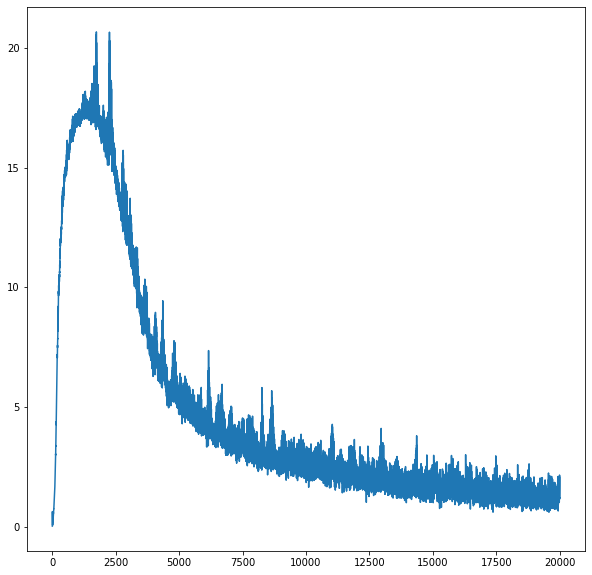

In [118]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

In [119]:
import numpy as np

X = np.linspace(-3, 3, 30)
Y = np.linspace(-3, 3, 30)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device)
grad_field = score_net(grid_tensor)
grad_field_np = grad_field.detach().cpu().numpy()
grad_field_np = grad_field_np[0]

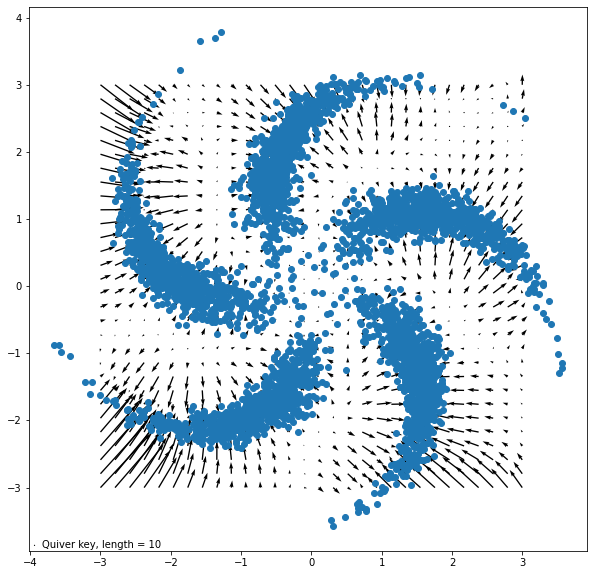

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
q = ax.quiver(grid[..., 0], grid[..., 1], grad_field_np[..., 0], grad_field_np[..., 1])
ax.quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
sample_data = toy_data.inf_train_gen('pinwheel', n_points=4096)
ax.scatter(sample_data[:, 0], sample_data[:, 1])
plt.show()

<Figure size 720x720 with 0 Axes>

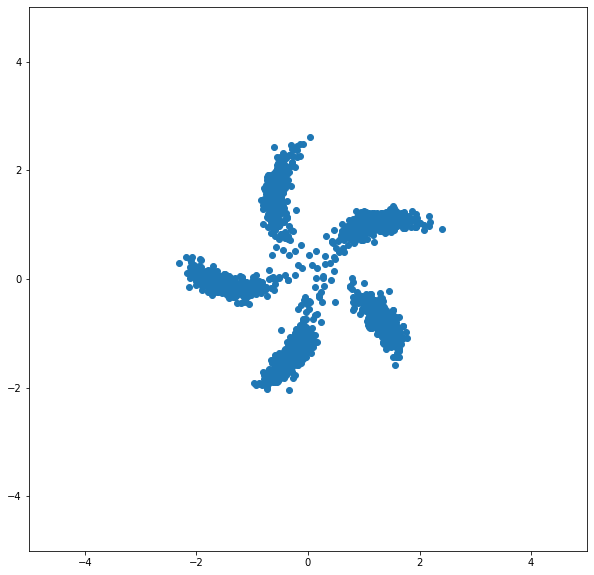

In [127]:
x_final = langevin_dynamics_lsd(score_net, l=0.004, e=.05, num_points=2048)
fig = plt.figure(figsize=(10, 10))
visualize_2d(x_final)